<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Water-Cloud-Model" data-toc-modified-id="The-Water-Cloud-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Water Cloud Model</a></span></li><li><span><a href="#The-soil-model" data-toc-modified-id="The-soil-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The soil model</a></span><ul class="toc-item"><li><span><a href="#A-purely-empirical-soil-model" data-toc-modified-id="A-purely-empirical-soil-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A purely empirical soil model</a></span></li><li><span><a href="#The-Oh-2004-soil-model" data-toc-modified-id="The-Oh-2004-soil-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>The Oh 2004 soil model</a></span></li><li><span><a href="#Towards-a-generic-soil-backscatter-model-for-WCM-inversions" data-toc-modified-id="Towards-a-generic-soil-backscatter-model-for-WCM-inversions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Towards a generic soil backscatter model for WCM inversions</a></span></li></ul></li><li><span><a href="#Initial-data-exploration" data-toc-modified-id="Initial-data-exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial data exploration</a></span></li><li><span><a href="#Biophysical-parameters-from-S2-using-KaSKA" data-toc-modified-id="Biophysical-parameters-from-S2-using-KaSKA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Biophysical parameters from S2 using KaSKA</a></span></li><li><span><a href="#Inversion-strategy" data-toc-modified-id="Inversion-strategy-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Inversion strategy</a></span><ul class="toc-item"><li><span><a href="#Additive-model-results" data-toc-modified-id="Additive-model-results-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Additive model results</a></span></li><li><span><a href="#Empirical,-Oh-2004-generalised-model-results" data-toc-modified-id="Empirical,-Oh-2004-generalised-model-results-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Empirical, Oh-2004 generalised model results</a></span></li></ul></li><li><span><a href="#Exploiting-the-change-signal" data-toc-modified-id="Exploiting-the-change-signal-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exploiting the change signal</a></span></li><li><span><a href="#Towards-a-combined-retrieval-strategy" data-toc-modified-id="Towards-a-combined-retrieval-strategy-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Towards a combined retrieval strategy</a></span></li></ul></div>

In [1]:
# Generic imports
%load_ext autoreload
%autoreload 2
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats 

%matplotlib inline

from SAR_retrieval_funcs import cost_function, fwd_model, extract_data
from SAR_retrieval_funcs import invert_field, do_plots, prepare_field_data

from SAR_retrieval_OLD import invert_field as invert_field_additive
from SAR_retrieval_OLD import do_plots as do_plots_additive

# Don't nag!
_ = np.seterr(divide='ignore', over="ignore", invalid='ignore')


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SAR/optical retrieval of biophysical parameters

This notebook deals with some experiments on retrieving biophysical parameters from combined optical/SAR. We first state an assumption that we take as a starting point: in a Bayesian paradigm, and provided that full pdf are considered, retrieval strategies can be broken in stages. This is important, because it means that we can decouple the optical retrievals from the SAR retrievals. Another important consideration is that we will not use overly complicated RT models for the SAR domain. While this would be desirable at least as a form of benchmarking, their complex and often abstract parameterisation suggests that it may be more fruitful to devote time to explore simple physical descriptions that are mostly compatible/equivalent to the optical domain.

## The Water Cloud Model

In this line, we consider that a first order water cloud model (WCM) is an acceptable starting point. The WCM has a long history behind, having been first introduced in the late 1970s. It basically describes backscatter as a sum (incoherent) of backscatter from a canopy, plus backscatter from soil, the latter attenuated by the canopy. Mathematically,


$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\sigma_{soil}^{pq}.
$$

$A_{pq}V_{1}$ can be seen as the single scattering albedo of the canopy, with $V_1$ accounting for vegetation optical depth (e.g. some form of scaled leaf area index, LAI). $V_2$ (and the closely associated $B_{pq}$) control the extinction due to canopy elements. It is likely that $V_2$ will be related to both LAI and moisture content. Finally, we assume a suitable model is available for $\sigma_{soil}$, which in general will be a functin of dielectric properties and roughness (so moisture and roughness with respect to radar's operating wavelength). Such a model as described here is probably valid for higher frequencies (C, X band and above). Lower frequencies might render the assumptions of incoherent scattering invalid due to very strong near field effects.

## The soil model

### A purely empirical soil model

Perhaps the simplest soil model is one that is linear and purely empirical, where the soil is assumed to be just a linear function of soil moisture. While clearly simplistic, as it ignores important angular backscatter effects, the model has the benefit of combining all these effects into a single non-important empirical constant. Assuming that the acquisition geometry does not vary much, the surface is smooth (with respect to the wavelength), then roughness and angular effects can all be lumped together with dielectric properties. Assuming that dielectric is only weakly non-linear (many authors go with a linear relationship, Hallikainen et al 1985 assumes a quadratic, but in most circumstances, well approximated by a linear function).

The advantage of this model is simplicity, and direct application to temporal series: it is often assumed that roughness is slowly varying in time. Its value is also hard to measure, and we are tacitly assuming that soil moisture is the most interesting parameter for end users (e.g. vegetation monitoring, numerical weather prediction, etc).

### The Oh 2004 soil model


The Oh 2004 model, which models soil backscatter for the VV, HH and HV polarisations as a function of volumetric soil moisture and a soil roughness term. Previous versions of the Oh model, and the Dubois models are also simple, but a bit more involved in their calculations. We'll take the Oh 2004 model, and have a poke around to see if we can get some insights that allow us to formulate a sensible inversion strategy.

The Oh model in essence can be written (for HV and VV polarisations) as a function of angle of incidence $\theta$, soil moisture $mv$ and wavenumber times rms roughness, $ks$. In this respect, this is compatible with our discussion above. The main point of interest is that the model is multifrequency. In this discussion, as we are mostly considering Sentinel 1, this is not a major advantage, but nevertheless allows for extensions to other sensors. THe following equations define the model for the VV and VH polarisations (an additional equation describes HH, not included here):

$$
\begin{align}
\sigma_{HV} &= a\cdot b\\
\sigma_{VV} &= \frac{a\cdot b}{q}\\
q_0(\theta) &= 0.095\cdot\left(0.13 + \sin(1.5\theta)\right)^{1.4}\\
f_{q}(ks) &= (1 - \exp(-1.3 \cdot ks^{0.9}))\\
a &= 0.11\cdot mv^{0.7}  \cos(\theta)^{2.2}\\
b &= 1-\exp(-0.32\cdot ks^{1.8})\\
\end{align}
$$

If $\theta$ is identical for both polarisations, we have that
$$
\begin{align}
\sigma_{HV} &= f_{A}(\theta)\cdot mv^{0.7}\cdot f_{b}(ks)\\
\sigma_{VV} &= f_{A}(\theta)\cdot \frac{f_{b}(ks)}{q_{0}(\theta)\cdot f_{q}(ks)}\cdot mv^{0.7}
\end{align}
$$

The multiplicative model in linear units becomes an additive model in dB, which goes back to our discussion in the previous section. In a way, following through with a simplifying zeal, we can see the Oh 2004 model as a way of providing a prior pdf for parameters that depend on roughness scales, illumination geometry, soil texture and wavelength. We note that the $ks$ parameter is a way of scaling up or down frequencies (as it represents a form of roughness scaled by wavelength). There's an intriguing concept if we can add some extra constraints on $ks$ to support retrieval within time series. 

These observations aren't extraordinary: a lot of approaches to soil moisture retrieval observe that changes in backscatter can directly be associated with soil moisture changes. Over small temporal windows, one can assume $ks$ constant, and if the surface isn't too rough, backscatter can be written as the product of roughness and a dielectric term. Thus one can use two or more observations to solve for the dielectric constant, and hence, $mv$. 

There is a large body of literature exploring these approaches for bare soils, and suggesting that this simple approaches will be appropriate for C, X and possibly even L band. The presence of a canopy can only be partially mitigated. Simple models such as the WCM provide strong attenuation, and thus render the contribution from the soil irrelvant for fairly low vegetation optical depths. More sophisticated models would also take into account the strong stalk/soil effect, and other higher order effects.

### Towards a generic soil backscatter model for WCM inversions

Rewriting the Oh 2004 model in dB scale, we have

$$
\begin{align}
\sigma_{hv} &= \log_{10}(fa_t) + \log_{10}(fb_k) + 0.7\cdot\log_{10}(mv) \\
\sigma_{vv} &= \left(\log_{10}(fa_t) - \log_{10}(q_{0})\right) \\
            &+ \left(\log_{10}(fb_k) - \log_{10}(fq_{k})\right) \\
            &+ 0.7*\log_{10}(mv) \\
\end{align}
$$

The first term on both equations is an angular term, whereas the second term is related to roughness. The third term is related to moisture. If we are not (initially) interested in roughness, we can just lump the roughness contributions into a polarisation-dependent parameter, e.g. $R_{pq}$, and we can then have a second, polarisation independent, moisture term $mv_{s}=0.7\log_{10}(mv)$, or even develop a more physically feasible model using Fresnel equations (a function of dielectric constant and angle of incidence), coupled with an empirical model that links dielectric constant to volumetric moisture content. 

The previous comments suggest  that we can probably fit the soil model using a time series, particularly if we are willing to drop explainability of soil roughness (although this can be retrieved at a latter stage).

The above comments results in the complete WCM being:

$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\left[K_{pq} + R_{pq} + mv_{s} \right].
$$

It's a simple model to differentiate, and for completeness, here are the partial derivatives (I define a few common functions at the top).


$$
\begin{align*}
\sigma_{soil} &= K_{pq} + R_{pq} + mv_{s}\\
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial \sigma_{pq}^{0}}{\partial A} &= V_{1} - V_{1}\tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial B} &= \frac{-2V_2}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pq}^{0}}{\partial V_{1}} &= A - A\tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial V_{2}} &= \frac{-2B}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pq}^{0}}{\partial mv_{s}} &= \tau\\
\frac{\partial \sigma_{pq}^{0}}{\partial R_{pq}} &= \tau\\
\end{align*}
$$



The outshoot of this is that a retrieval strategy based on de-coupling angles, roughness and moisture is possible and not overly complicated. Under the assumption that roughness is slowly varying in time for the same location, we have a two or three parameter retrieval strategy (e.g. $mv,\,f_{B}(ks)$ and $f_{q}(ks)$). What's neat is that these parameters are **shared between polarisations**. We can improve further by providing prior distributions on some (or all) of these parameters. These could come from experience, from fitting more complex electromagnetic models or from nearby retrievals.


## Initial data exploration

Let's now have a look at some data


Text(0.5, 0, 'DoY/2017')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


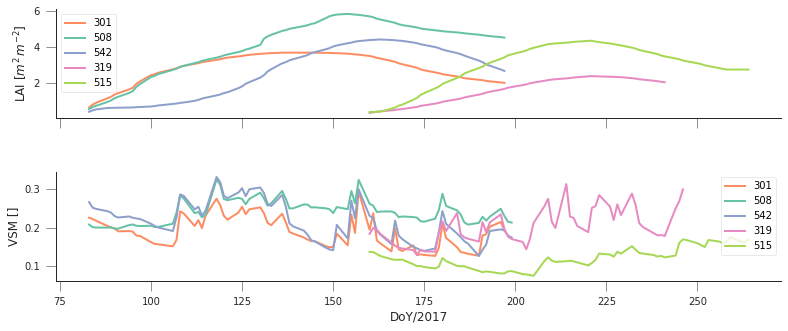

In [2]:
df, df_s2, fields = extract_data()

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], df[f"LAI_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")


axs[0].set_ylabel(r"LAI $[m^2\,m^{-2}]$")
axs[1].set_ylabel("VSM []")
axs[1].set_xlabel("DoY/2017")

The previous plots show the *in situ* measured LAI and soil moisture for 5 different fields. The LAI clearly shows the difference between winter and summer crops. The soil moisture shows significant differences between fields. Although fast varatins (e.g. recharges due to rainfall events) are similar in many fields, each field is slightly different, and in the plots, there's is not enough overlap to obscure the individual field soil moisture trajectories. 

We can now have a look at backscatter:



Text(0.5, 0, 'DoY/2017')

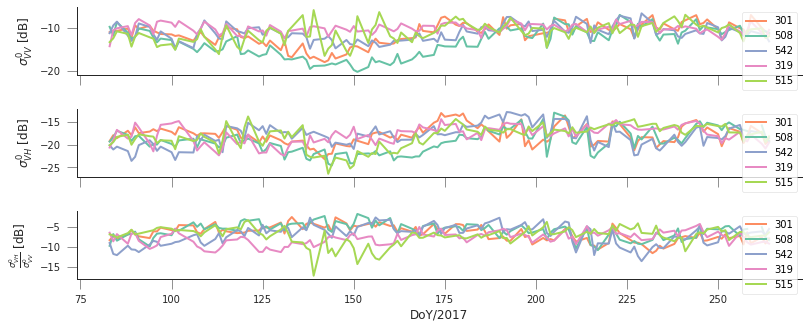

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 5))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], 10*np.log10(df[f"sigma_sentinel_vv_{field:s}"]),
                          label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], 10*np.log10(df[f"sigma_sentinel_vh_{field:s}"]),
                          label=field))

    l3.append(axs[2].plot(df[f"doy_{field:s}"], 10*np.log10(
        df[f"vh/vv_{field:s}"]),
        label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"$\sigma^{0}_{VV}$ [dB]")
axs[1].set_ylabel(r"$\sigma^{0}_{VH}$ [dB]")
axs[2].set_ylabel(r"$\frac{\sigma^{0}_{VH}}{\sigma^{0}_{VV}}$ [dB]")
axs[2].set_xlabel("DoY/2017")

The picture above is complicated by the fact that different orbits are present in the data, changing acquisition geometries and adding an extra level or variation.

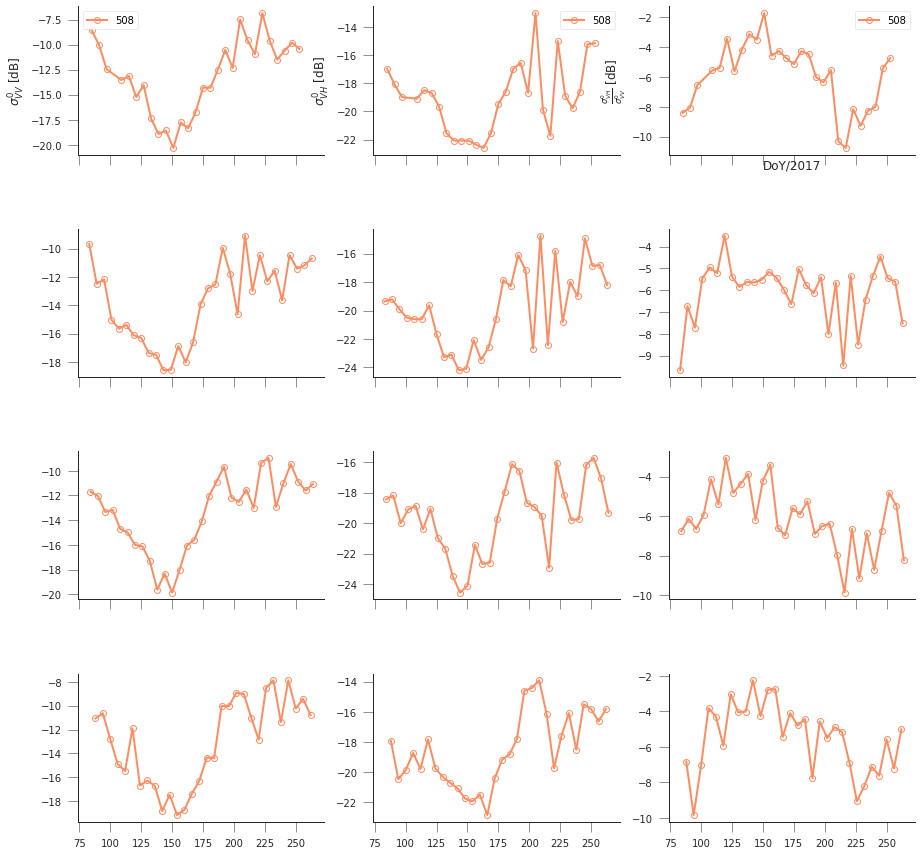

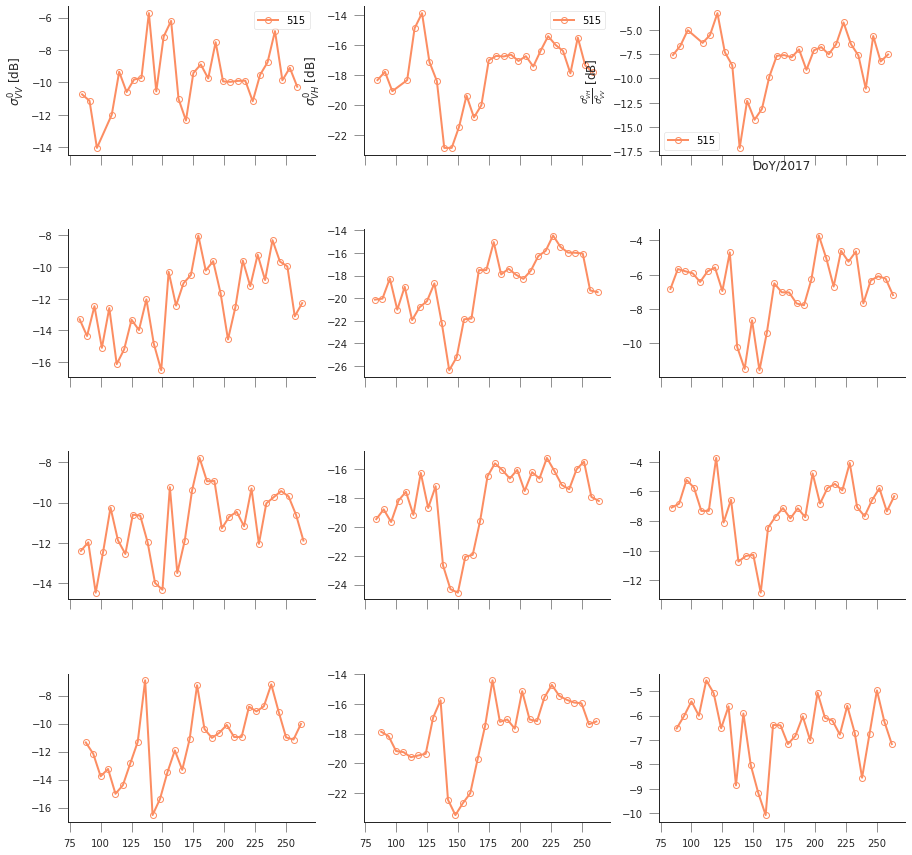

In [4]:
for field in ["508", "515"]:
    fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True,
                            squeeze=True, figsize=(15,15))
    for ii, orbit_no in enumerate([44, 95, 117, 168]):
        l1 = []
        l2 = []
        l3 = []

        passer = df[f"relativeorbit_{field:s}"] == orbit_no
        l1.append(axs[ii][0].plot(df[f"doy_{field:s}"][passer],
                                  10*np.log10(df[f"sigma_sentinel_vv_{field:s}"][passer]),
                                  "-o", label=field,  mfc="none"))
        l2.append(axs[ii][1].plot(df[f"doy_{field:s}"][passer], 
                                  10*np.log10(df[f"sigma_sentinel_vh_{field:s}"][passer]),
                                  "-o",label=field, mfc="none"))

        l3.append(axs[ii][2].plot(df[f"doy_{field:s}"][passer],
                                  10*np.log10(
            df[f"vh/vv_{field:s}"][passer]),
             "-o",label=field, mfc="none"))

    axs[0,0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
    axs[0,1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
    axs[0,2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


    axs[0,0].set_ylabel(r"$\sigma^{0}_{VV}$ [dB]")
    axs[0,1].set_ylabel(r"$\sigma^{0}_{VH}$ [dB]")
    axs[0,2].set_ylabel(r"$\frac{\sigma^{0}_{VH}}{\sigma^{0}_{VV}}$ [dB]")
    axs[0,2].set_xlabel("DoY/2017")

So we see above that the different orbits (ascending, descending, different incidence angles) all add a number of important changes to the recorded backscatter. Correcting for these effects might not be possible just by having a single path length through the canopy correction as shown in the original WCM model. Differences of one to two dB are the kind of sensitivity to soil moisture we are after.

## Biophysical parameters from S2 using KaSKA

We have used KaSKA to retrieve land surface parameters. These are provided on a 20m resolution grid and are reported every 5 days. I have averaged them over each field. Note that this might have actually included some boundary pixels, but hey...

Let's have a look at how things stack up.

(0, 1)

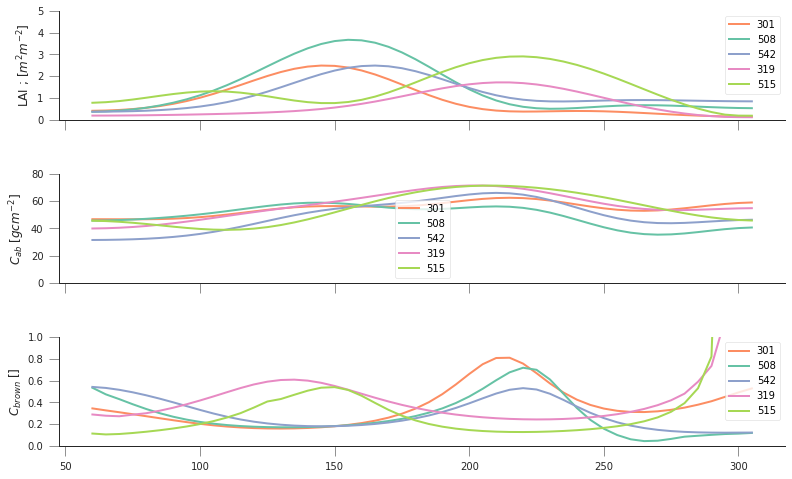

In [5]:

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,
                        squeeze=True, figsize=(13, 8))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df_s2.doy, df_s2[f"lai_{field:s}"],
                          label=field))
    l2.append(axs[1].plot(df_s2.doy, df_s2[f"cab_{field:s}"],
                          label=field))
    l3.append(axs[2].plot(df_s2.doy, df_s2[f"cbrown_{field:s}"],
                          label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"LAI ; $[m^{2}m^{-2}]$")
axs[1].set_ylabel(r"$C_{ab}\;[gcm^{-2}]$")
axs[2].set_ylabel(r"$C_{brown}\;[]$")
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 80)
axs[2].set_ylim(0, 1)

Mostly, LAI appears to be underestimated, and is clearly oversmoothed, but other than that, temporal trends look comparable with what we see in backscatter.

## Inversion strategy

The main assumptions we are making are

* $V_1=V_2=LAI$ This might require further refinement, but basically, $V_i$ are canopy optical thickness.
* Assume that there's a strong correlation between $\sigma_{soil}$ in VV and VH polarisations.
* If we exploit the S2 LAI data and some uncertainty, we might want to let it float (e.g. update it with the S1 data). There's a risk that we compensate WCM model limitations by changing LAI, so we probably want to keep LAI uncertainty "manageable" (low!)
* We might want to assume smoothness in LAI, but not in soil moisture (it's clearly peaky for rainfall events).
* We might want to also assume smoothness in soil roughness.
* We don't really have a clue about $A_{pq}$, $B_{pq}$ and $C_{pq}$ parameters. We may have a first guess on $\sigma_{soil}$ when $LAI$ is low, and one could probably make a similar claim for $A\cdot V_1$. 
* The last point is just a trick to get a starting point for the minimisation, but ideally, we'd like to have some form of prior PDF for the WCM parameters.

All this is implemented in a bunch of functions, but the one you may want to look at with more pause is rather unsurprisingly `cost_function`, which bundles everything together. The uncertainty in SAR has been assumed to be 0.5 dB, but that can obviously be changed to deal with changes in speckle filtering and stuff like that.

Let's see how this works for the different fields...


### Additive model results
First, the simple additive model results. We will focus on the winter wheat field (508), as the signal appears to be quite strong and simple to interpret.

Initial cost 227599
Final cost 1811.02
[ -4.07724078   0.07443628 -10.98971405  -4.74978974   0.0332928
 -18.05826271]


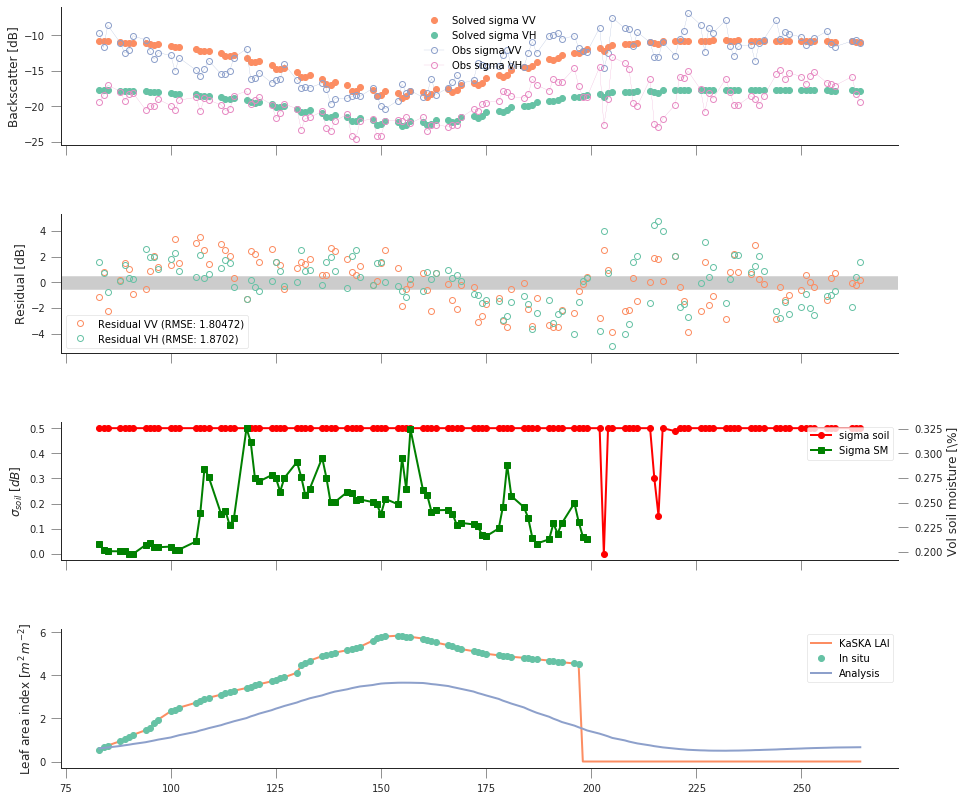

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
field = "508"

doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown, lai = prepare_field_data(
    field, df, df_s2)
lai[76:]=0
sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0) *12.88
sm_std = 20. * np.nanstd([df[f"SM_{field:s}"][passer] for field in fields],
                         axis=0)
sm_std[sm_std == 0] = 0.3
sm_std = sm_std *0 + 0.5

prior_mean = np.concatenate([[
    0,
] * 6, sm_mean, s2_lai])
prior_sd = np.concatenate([[
    1.,
] * 6, sm_std, [
    0.025,
] * n_obs])
gamma = 200
retval, residual = invert_field_additive(svv, svh, theta, prior_mean, prior_sd,
                                     gamma, lai)

do_plots_additive(field, retval, svv, svh, theta, doy, df, lai)
print(retval.x[:6])


In [7]:
retval.x

array([ -4.07724078,   0.07443628, -10.98971405,  -4.74978974,
         0.0332928 , -18.05826271,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5 

In [8]:
print(aaa[11])
print(s2_lai[11])

NameError: name 'aaa' is not defined

First observation is that the model is very capable of fitting the observations. The residuals for both polarisations are on average 3-4 dB from the original measurements, but note that we haven't separated by orbits (this appears to have an effect of around 2-3 dB). The model struggles to fit the observations towards the end (after DoY 200), with large swings in the signal aren't accommodated by the solution, and similarly, the solution seems to do a poor job before DoY 100. Going to the LAI plot, the solution is acceptable within the vegetation period (e.g. $LAI>1$ roughly). Soil moisture is poorly retrieved outside the  main vegetative period. It is surprising that our soil moisture retrieval is better with vegetation than without. An explanation for this behaviour is that we start with a pretty good prior, and due to the combined effect of strong attenuation and limited sensitivity, the solution does not depart much from the prior. Feel free to try another prior mean value. Note that our $B_{VV}$ and $B_{VH}$ parameters are quite high (around 0.30 and 0.12, respectively), which leads to significant attenuation for LAI.

### Empirical, Oh-2004 generalised model results

Let's see the same field with the model based on Oh 2004. The  results are presented below. The setup is the same as for the previous example (same priors etc).

Initial cost 56034.5
Final cost 2718.42
[-4.35489815e+00  1.79399329e+00 -4.00000000e+00  3.00702567e+01
 -2.83903668e-03 -4.00000000e+00  1.69832544e-01  1.63398659e-01
  1.71769399e-01  1.59628643e-01]


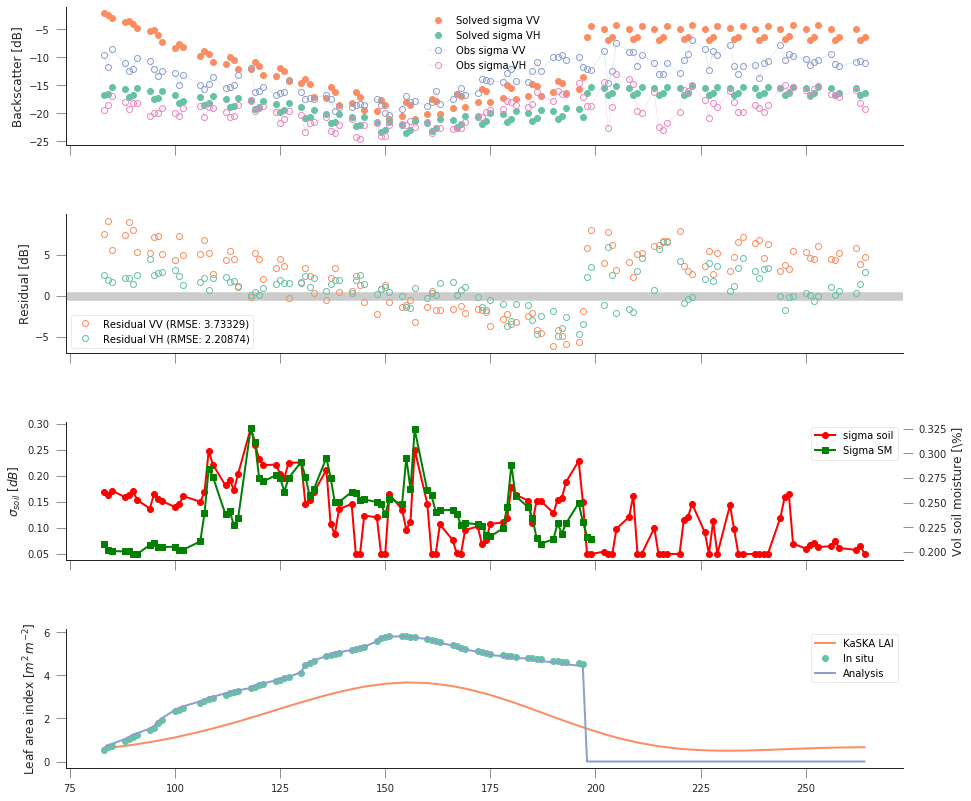

In [197]:
from scipy.ndimage.filters import gaussian_filter1d
field = "508"


doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown, lai = prepare_field_data(field, df, df_s2)
lai[76:]=0
sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_mean = sm_mean + 0.03
sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                        for field in fields], axis=0)
sm_std[sm_std == 0] = 0.2
sm_std = sm_std *0 + 0.5


prior_mean = np.concatenate([[0,]*6, sm_mean, lai])
prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
gamma = 10
retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, lai)

do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)
print(retval.x[:10])

In [161]:
sm_mean

array([0.73383333, 0.7255    , 0.72246667, 0.71623333, 0.71386667,
       0.7089    , 0.7051    , 0.70923333, 0.7082    , 0.703     ,
       0.702     , 0.69293333, 0.68836667, 0.68676667, 0.68463333,
       0.71163333, 0.7713    , 0.7653    , 0.73013333, 0.7387    ,
       0.71926667, 0.73686667, 0.811     , 0.79623333, 0.76316667,
       0.75646667, 0.76973333, 0.77746667, 0.75953333, 0.77433333,
       0.78293333, 0.76826667, 0.7441    , 0.7423    , 0.77236667,
       0.74836667, 0.717     , 0.7131    , 0.70926667, 0.70366667,
       0.69513333, 0.69423333, 0.68363333, 0.68043333, 0.67683333,
       0.71536667, 0.6917    , 0.7668    , 0.72503333, 0.80636667,
       0.70182   , 0.7115    , 0.68516   , 0.67876   , 0.6638    ,
       0.68514   , 0.66316   , 0.66064   , 0.65598   , 0.64646   ,
       0.64674   , 0.64434   , 0.6459    , 0.67376   , 0.71626   ,
       0.68918   , 0.68384   , 0.66628   , 0.65792   , 0.65364   ,
       0.64384   , 0.67016   , 0.66686   , 0.68456   , 0.6953 

First coment here is that the fit to the observations is now much poorer, particularly for the no vegetation period. It appears that the new model offers little to recommmend it: although in theory it has more parameters (and some kind of acounting for angles), LAI is forced to account for changes in the SAR signal when there's little LAI. This is worrying, but could be an effect of different geometries causing trouble. If this is the case, then the angular correction factors are not really robust enough to deal with the problem.

We explore per-orbit processing in the next couple of cells.

In [52]:
lai

array([0.5529, 0.6689, 0.7429, 0.9478, 1.0321, 1.1585, 1.2393, 1.4535,
       1.5537, 1.7947, 1.9487, 2.3373, 2.4033, 2.5022, 2.733 , 2.7989,
       2.8978, 2.961 , 3.1103, 3.1611, 3.2373, 3.286 , 3.4151, 3.466 ,
       3.5422, 3.5909, 3.7271, 3.7811, 3.8621, 3.9139, 4.1244, 4.4639,
       4.5972, 4.6824, 4.8992, 4.9448, 5.0131, 5.0568, 5.1726, 5.2182,
       5.2865, 5.3302, 5.6111, 5.7144, 5.7724, 5.8095, 5.8435, 5.8289,
       5.8071, 5.7931, 5.7105, 5.6582, 5.5797, 5.5295, 5.3994, 5.3483,
       5.2717, 5.2228, 5.1271, 5.0915, 5.038 , 5.0039, 4.933 , 4.9136,
       4.8845, 4.866 , 4.8167, 4.7973, 4.7683, 4.7475, 4.6899, 4.6673,
       4.6333, 4.6116, 4.554 , 4.5313,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
      

In [ ]:
field = "508"


for orbit_no, orbit_data in prepare_field_data(
                            field, df, df_s2, ignore_orbits=False).items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data

    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                            for field in fields], axis=0)
    sm_std[sm_std == 0] = 0.2



    prior_mean = np.concatenate([[0,]*6, sm_mean, aaa])
    prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
    
    gamma = 500
    retval = invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, aaa)

    do_plots(field, retval, svv, svh, theta, doy, df, s2_lai)
    print(retval.x[:10])

Initial cost 2472.35
Final cost nan
[ -4.07045728   0.09778033 -10.39770964  -2.16878339   0.07052103
 -18.0315435    0.41068375   0.27177823   0.16245074   0.2230941 ]
Initial cost 2261.08
Final cost 1014.09
[ -5.00557644   0.04677916 -11.45645887  -4.38729752   0.04057443
 -18.09532634   0.47066498   0.10431705   0.10830447   0.        ]
Initial cost 2128.09
Final cost 997.258
[ -3.82864371   0.07458646 -11.07434981  -2.78237201   0.06284056
 -18.11124726   0.19360161   0.18921102   0.           0.04783387]
Initial cost 2439.07
Final cost 959.428
[-6.16131152e+00  5.83164048e-02 -1.00682666e+01 -3.98990087e+00
  4.78083493e-02 -1.69759039e+01  2.07612939e-01  5.28210865e-02
  0.00000000e+00  8.45906766e-03]


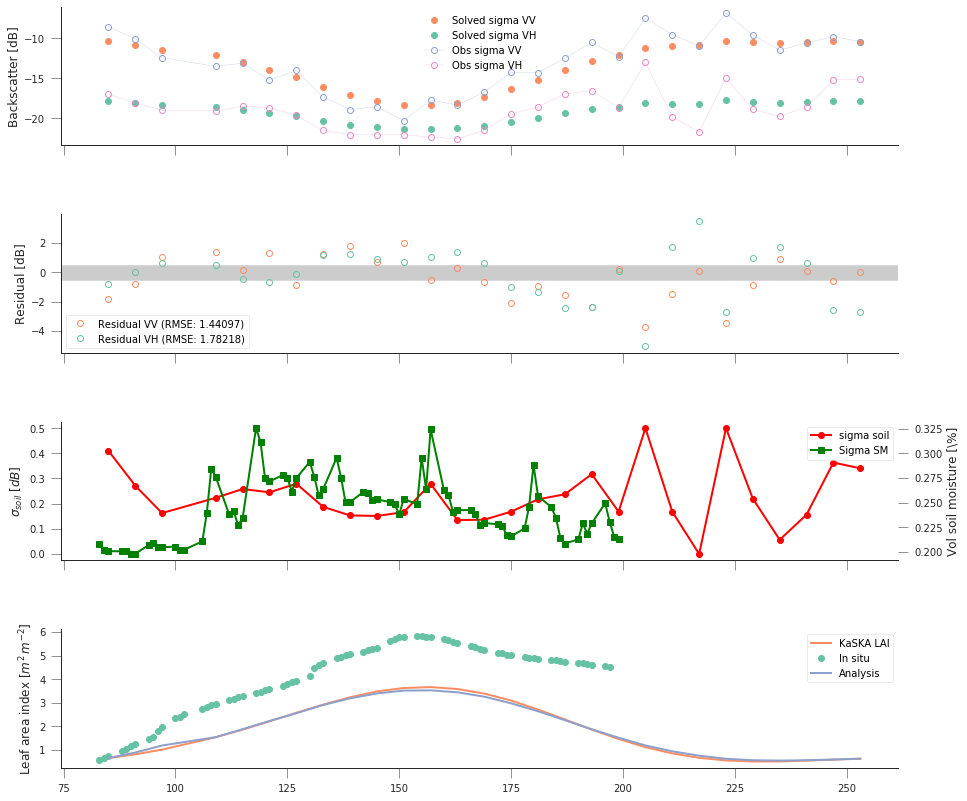

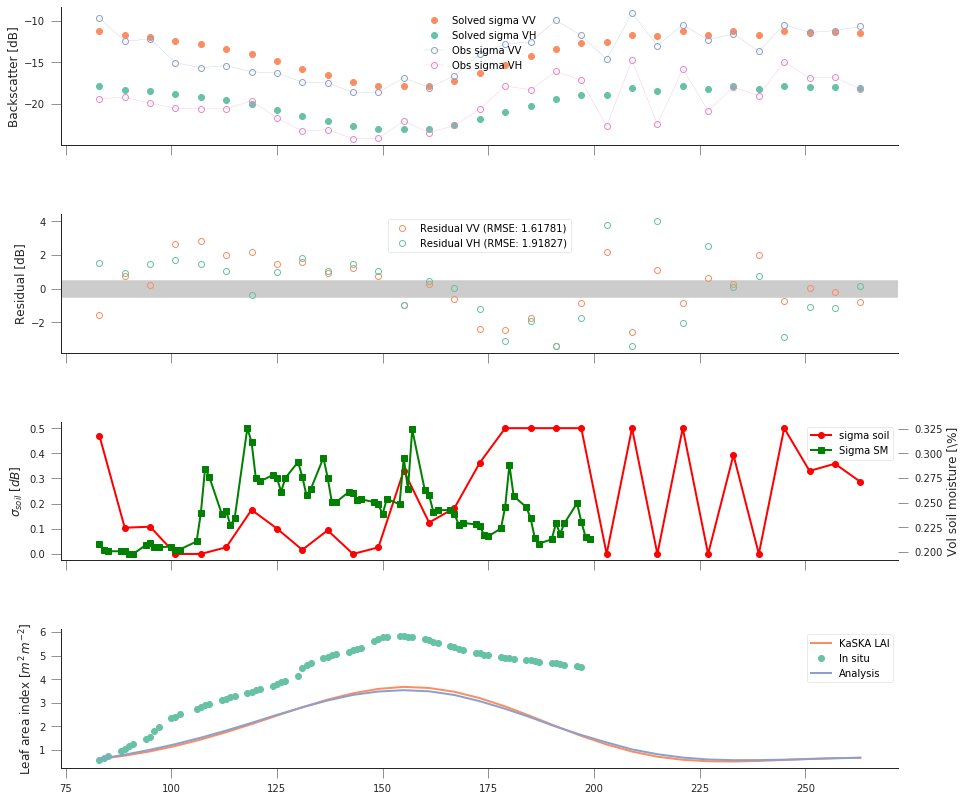

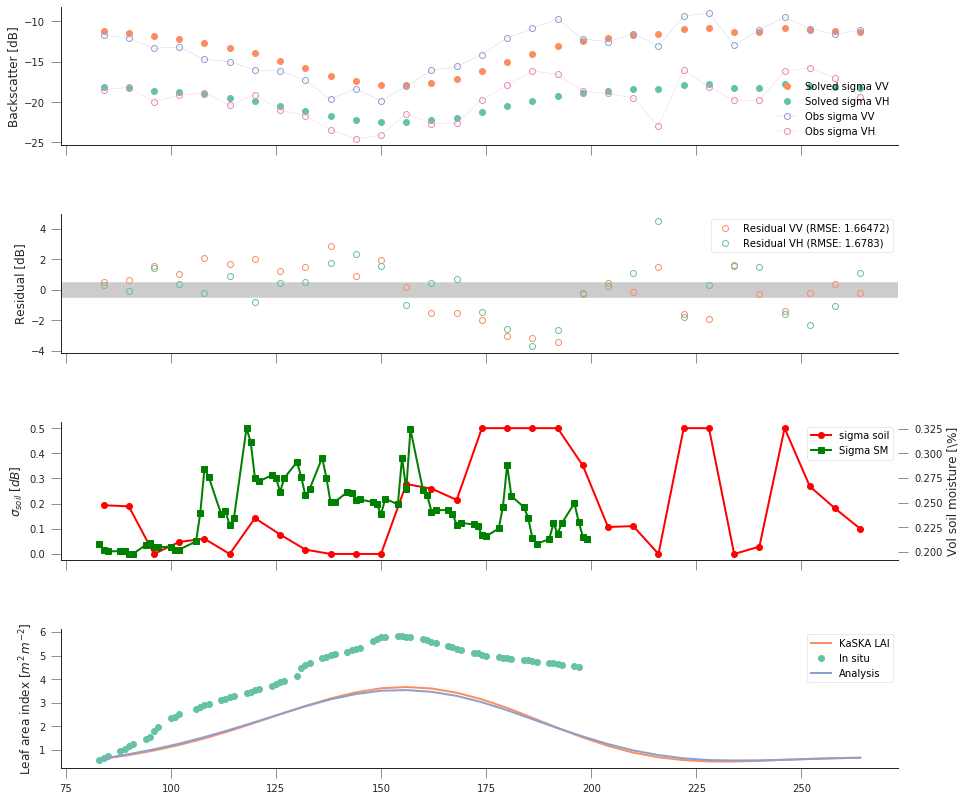

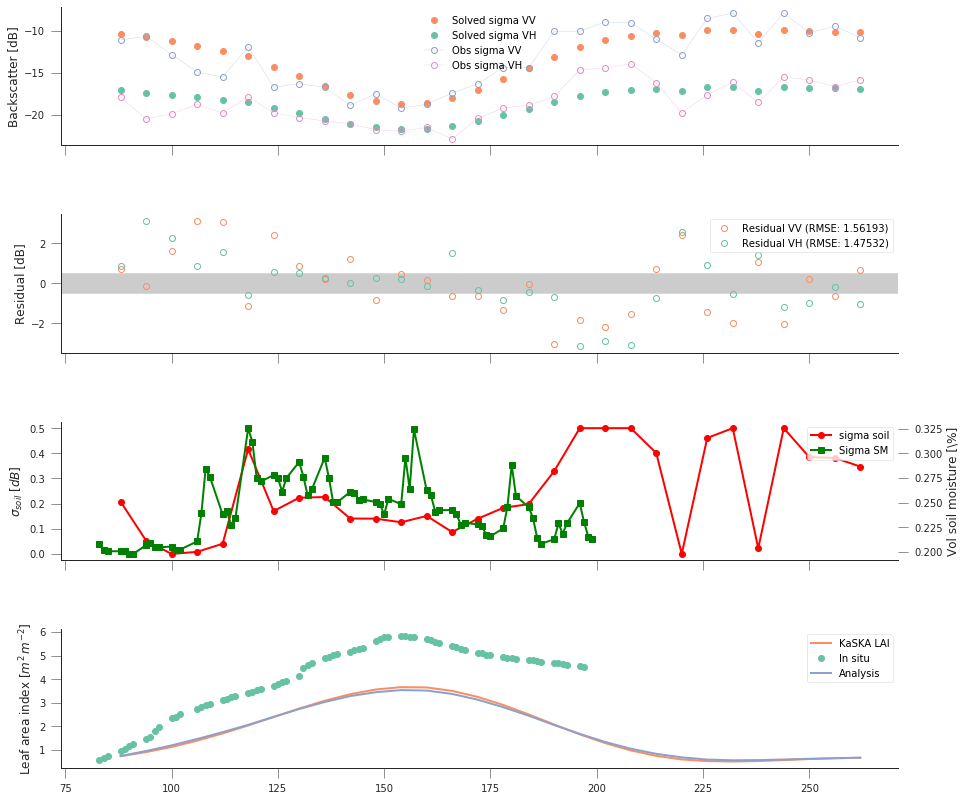

In [118]:
field = "508"


for orbit_no, orbit_data in prepare_field_data(
                            field, df, df_s2, ignore_orbits=False).items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data

    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_std = 20.*np.nanstd([df[f"SM_{field:s}"][passer]
                            for field in fields], axis=0)
    sm_std[sm_std == 0] = 0.2



    prior_mean = np.concatenate([[0,]*6, sm_mean, s2_lai])
    prior_sd = np.concatenate([[10., ]*6, sm_std, [0.05, ]*n_obs])
    gamma = 500
    retval, residuals = invert_field_additive(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)

    do_plots_additive(field, retval, svv, svh, theta, doy, df, s2_lai)
    print(retval.x[:10])

In [117]:
s2_lai

array([0.64989376, 0.80888052, 1.00855342, 1.53540758, 1.857525  ,
       2.20994162, 2.57105898, 2.91959988, 3.2308828 , 3.4791005 ,
       3.62504012, 3.66192296, 3.58177646, 3.3870407 , 3.0909455 ,
       2.70954316, 2.2884166 , 1.86144724, 1.46066876, 1.1126211 ,
       0.84700896, 0.66085241, 0.55036217, 0.50432916, 0.50669473,
       0.5412761 , 0.58524838, 0.6254977 ])

Processing per orbit yields similar results to processing with everything crumpled together. There is less fuzziness in the data (which neither of the models is able to account for, suggesting that small variations in angle of incidence aren't properly managed). Again, the model based on Oh2004 isn't really doing anything great.

## Exploiting the change signal

The temporal signal has been successfully used to extract soil moisture between contiguous observations. The idea is similar to the one mentioned above: if the soils are smoot(ish), and the time difference between acquisitions is small and there are no other complicating factors (e.g. geometry), then the difference in backscatter between two observations can be attributed to the change in dielectric properties. So if the copolar backcatter can be written as $\sigma_{pp}(t)=F(ks, \theta, t)\cdot\alpha(\epsilon, \theta, t)$, we a ratio between consecutive days is only controlled by $\alpha$. If we use the same acquisition geometry, the only parameter that changes is $\epsilon$, which we can relate to soil moisture. $\alpha$ can be calculatd using Fresnel reflection coefficients,  which coupled with a Dobson/Hallikainen type of dielectric constant model (usually based on soil texture), close the circle from backscatter to soil moisture. 


In [11]:


def cost(alphas, sr):
    J = 0
    for i in range(len(alphas)-1):
        J += (alphas[i] - sr[i] * alphas[i+1])**2
    return J

def fresnel(eps, theta):
    theta = np.deg2rad(theta)
    num = (eps-1)*(np.sin(theta)**2 - eps*(1+np.sin(theta)**2))
    den = eps*np.cos(theta) + np.sqrt(eps - np.sin(theta)**2)
    den = den**2
    return np.abs(num/den)

def mv2eps(a, b, c, mv):
    eps = a + b * mv + c * mv**2
    return eps

def cost_cost(p, theta, svv):
    lsvv = 10**(svv/ 10 )
    sr = np.sqrt(lsvv[:-1]/lsvv[1:])
    a,b,c = p[:3]
    mv = p[3:]
    eps = mv2eps(a, b, c, mv)
    alphas = fresnel(eps, theta)
    return cost(alphas, sr)

/home/tweiss/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


> /media/tweiss/Work/GIT/GitHub/jgomezdans/sar_homework/SAR_retrieval_funcs.py(299)prepare_field_data()
-> orbit_data[orbit] = [doy, passer, n_obs, svv, svh, theta,
(Pdb) lai
array([0.9102, 1.4399, 2.0945, 2.9559, 3.198 , 3.4155, 3.5683, 3.6659,
       3.6917, 3.6926, 3.6633, 3.5788, 3.3643, 3.0459, 2.7111, 2.463 ,
       2.2481, 2.0991,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan])
(Pdb) c
> /media/tweiss/Work/GIT/GitHub/jgomezdans/sar_homework/SAR_retrieval_funcs.py(298)prepare_field_data()
-> pdb.set_trace()
(Pdb) c
> /media/tweiss/Work/GIT/GitHub/jgomezdans/sar_homework/SAR_retrieval_funcs.py(299)prepare_field_data()
-> orbit_data[orbit] = [doy, passer, n_obs, svv, svh, theta,
(Pdb) c
> /media/tweiss/Work/GIT/GitHub/jgomezdans/sar_homework/SAR_retrieval_funcs.py(298)prepare_field_data()
-> pdb.set_trace()
(Pdb) c


ValueError: too many values to unpack (expected 9)

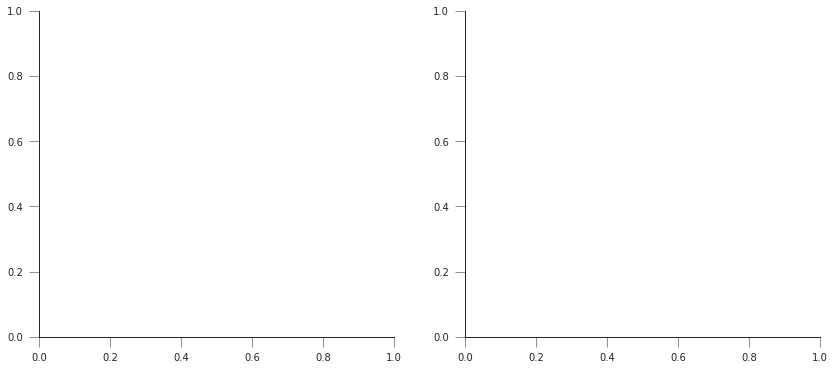

In [12]:
soil_parameters = {}
retrieved_soil_moisture = {}
in_situ_soil_moisture = {}

num_day = 20
bounds = [[None, None]] * 3 + [[0.1, 0.5]] * num_day
xs = []
ys = []
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs = axs.flatten()
for field in ["301", "508", "542"]:
    soil_parameters[field] = []
    retrieved_soil_moisture[field] = []
    in_situ_soil_moisture[field] = []

    dpasser = np.logical_and(df[f"doy_{field:s}"].values >= 80,
                             df[f"doy_{field:s}"].values <= 140)

    in_situ_soil_moisture[field] = np.c_[df[f"doy_{field:s}"][dpasser],
                                         df[f"SM_{field:s}"][dpasser]]

    for orbit_num, orbit_data in prepare_field_data(
            field, df, df_s2, ignore_orbits=False).items():
        doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data

        tmv = np.array(df[f"SM_{field:s}"][df[f"doy_{field:s}"] == doy[0]])

        x0 = (np.ones(3) * 0.4).tolist() + (np.ones(num_day) * tmv).tolist()

        retval = scipy.optimize.minimize(cost_cost,
                                         x0,
                                         jac=False,
                                         args=(theta[:num_day], svv[:num_day]),
                                         method="L-BFGS-B",
                                         options={"disp": True},
                                         bounds=bounds)
        soil_parameters[field].append(retval.x[:3])
        retrieved_soil_moisture[field].append(
            np.c_[doy[:num_day], retval.x[3:]])
        mask = (doy[:num_day] > 80) & (doy[:num_day] < 100)
        xs += retval.x[3:][mask].tolist()
        ys += [
            df[f"SM_{field:s}"][df[f"doy_{field:s}"] == ii].values[0]
            for ii in doy[:num_day][mask]
        ]

        for xx in retrieved_soil_moisture[field]:

            axs[0].plot(xx[:, 0], xx[:, 1], 'o', c="#A6D854")
        axs[0].plot(in_situ_soil_moisture[field][:, 0],
                 in_situ_soil_moisture[field][:, 1], '-', lw=0.5)#, c="#E78AC3")
        axs[0].set_xlim(80, 120)

axs[1].plot(ys, xs, 'o')
from scipy.stats import linregress

retval = linregress(ys, xs)
axs[1].plot([0.1, 0.3], [0.1, 0.3], 'k--', lw=0.5)
xx = np.array([0.1, 0.3])
axs[1].plot(xx, retval.slope*xx + retval.intercept, '-')
axs[1].set_title(f"R^2 {retval.rvalue**2:g}\nSlope {retval.slope:g}\nIntercept {retval.intercept:g}")
for k,v in soil_parameters.items():
    n_orbits = len(v)
    for i in range(n_orbits):
        print(f"{k:s} => a={v[i][0]:f}; b={v[i][1]:f}; c={v[i][2]:f}")


## Towards a combined retrieval strategy

From the previous discussions we can make two claims:
* we can fit the observations pretty well when we use the optical LAI to account for vegetation optical depth
* for bare soils, we can can interpret changes in backscatter to changes in soil moisture and solve for them

Putting both comments together suggests that we could potentially use the WCM to remove the canopy effect from the soil signal (up to a point!), and then apply the bare soils technique on the residuals. Clearly, the soil signal under the canopy might be strongly attenuated and may thus be very uncertain.

We can see how this fits with the framework defined above. We extend the original WCM to
$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\left[R_{pq}(\theta) + \alpha(mv_{s},\theta) \right].
$$

where $R_{pq}$ is the soil roughness for polarisation $pq$ and $\alpha$ is the Fresnel reflection coefficient for VV (or HH). We assume  that $R$ change smoothly over time. $A_{pq}$ and $B_{pq}$ are assumed constants over the entire time series, and $V_{1}$ and $V_{2}$ are provided by optically estimated LAI (assumed smooth). The system is further enhanced by a prior parameter distribution



Initial cost 3178.01
Final cost 800.507
5.104673506893447
0.17931438666594324
Initial cost 3373.08
Final cost 943.679
3.7963009031197164
0.5249293553592186
Initial cost 3241.84
Final cost 777.1
4.691535217976212
0.16393933954072176
Initial cost 3372.73
Final cost 742.487
4.290409147233013
0.6788793453364679


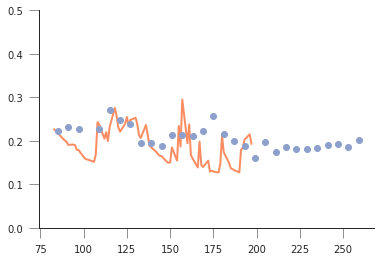

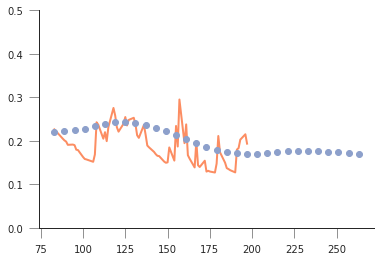

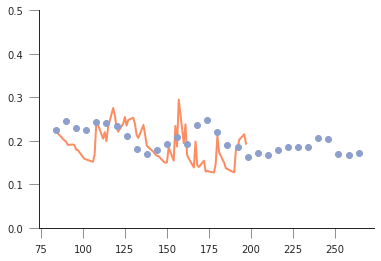

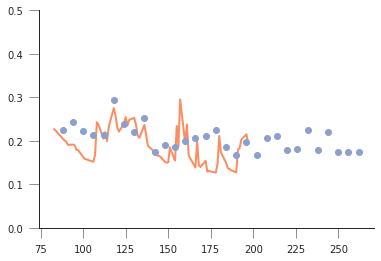

In [357]:
from SAR_retrieval_machinery import *

field = "301"
for orbit_no, orbit_data in prepare_field_data(
                            field, df, df_s2, ignore_orbits=False).items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown, lai = orbit_data
    lai[18:]=0
    lai = lai
    #print(lai)
    ##rr = np.ones_like(passer, dtype=np.float32)*np.nan
    
    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_mean = gaussian_filter1d(sm_mean, 3)
    alpha_mean = fresnel(mv2eps(1.99, 38.9, 11.5, sm_mean), theta.mean())
    #sm_std = 5.*np.nanstd([df[f"SM_{field:s}"][passer]
    #                        for field in fields], axis=0)
    #sm_std[sm_std == 0] = 0.2
    #print(sm_std)
    alpha_std = np.ones_like(alpha_mean)*0.2
    
    


    prior_mean = np.concatenate([[0,]*6, alpha_mean, np.zeros_like(sm_mean), s2_lai])
    prior_sd = np.concatenate([[10., ]*6, alpha_std, [0.1,]*n_obs, [0.05, ]*n_obs])
    gamma = (10000, 1000)
    retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)
    plt.figure()
    
    #plt.plot(doy, retval.x[6:(6+len(svv))], 'o')
    alpha = retval.x[6:(6+len(svv))]
    #print(alpha)
    #print('alpha')
    sols = quad_approx_solver(1.99, 38.9, 11.5,theta, alpha)
    
    plt.plot(df["doy_301"], df["SM_301"])
    plt.plot(doy, [s[0] for s in sols], 'o')
    plt.plot(doy, [s[1] for s in sols], 'o')
    plt.ylim(0,0.5)
    
    rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,np.array([s[1] for s in sols]))
    slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,np.array([s[1] for s in sols])[:len(df[f"SM_{field:s}"][passer].dropna().values)])
    print(rmse*100)
    print(r_value)
    


[0.6419 0.8056 0.9102 1.1552 1.2375 1.361  1.4399 1.6492 1.7441 1.9579
 2.0945 2.4384 2.4931 2.5752 2.7667 2.8214 2.9034 2.9559 3.0726 3.1089
 3.1632 3.198  3.2901 3.3264 3.3808 3.4155 3.4824 3.5072 3.5445 3.5683
 3.6285 3.6393 3.6555 3.6659 3.6912 3.6914 3.6916 3.6917 3.6921 3.6923
 3.6925 3.6926 3.6812 3.6761 3.6683 3.6633 3.6363 3.6197 3.5947 3.5788
 3.5068 3.4656 3.4038 3.3643 3.2319 3.1781 3.0974 3.0459 2.9045 2.8486
 2.7647 2.7111 2.5916 2.5544 2.4986 2.463  2.3685 2.3313 2.2755 2.2481
 2.185  2.1601 2.1229 2.0991 2.0359 2.0111 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.    ]
Initial cost 29524.3
Final cost 1583.77
(22.714061378410822-9.942328922343176j)
(-0.052207003804219755-0.12746302253525435j)
13.58796804792213
-0.0410356333965

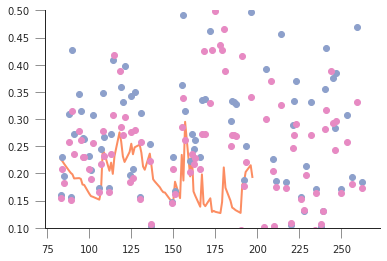

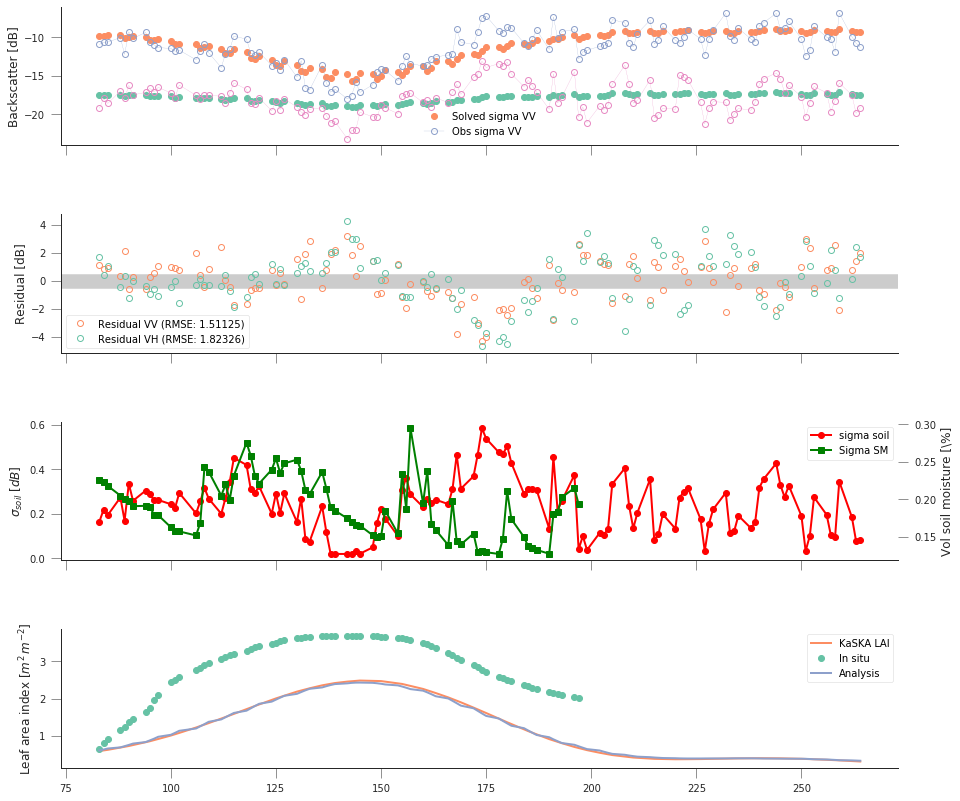

In [702]:
from SAR_retrieval_machinery import *
import random

field = "301"

doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown, lai = prepare_field_data(
    field, df, df_s2)


lai[76:]=0
lai = lai
print(lai)
##rr = np.ones_like(passer, dtype=np.float32)*np.nan

sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
sm_mean = gaussian_filter1d(sm_mean, 3)
alpha_mean = fresnel(mv2eps(1.99, 38.9, 11.5, sm_mean), theta.mean())
alpha_mean = np.array([sm+random.uniform(0,0.05) for sm in sm_mean])
alpha_mean = sm_mean
#sm_std = 5.*np.nanstd([df[f"SM_{field:s}"][passer]
#                        for field in fields], axis=0)
#sm_std[sm_std == 0] = 0.2
#print(sm_std)
alpha_std = np.ones_like(alpha_mean)*0.2




prior_mean = np.concatenate([[0,]*6, alpha_mean, np.zeros_like(sm_mean), s2_lai])
# prior_mean = np.concatenate([[0,]*6, alpha_mean, np.zeros_like(sm_mean), s2_lai**2*s2_cab/100])
prior_sd = np.concatenate([[10., ]*6, alpha_std, [0.1,]*n_obs, [0.05, ]*n_obs])
gamma = (5000, 5000)
retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)
# retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai**2*s2_cab/100)
plt.figure()

#plt.plot(doy, retval.x[6:(6+len(svv))], 'o')
alpha = retval.x[6:(6+len(svv))]
ruff = retval.x[6+n_obs:(6+n_obs*2)]
#print(alpha)
#print('alpha')
sols = quad_approx_solver(1.99, 38.9, 11.5,theta, alpha)

plt.plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"])
plt.plot(doy, [s[0] for s in sols], 'o')
plt.plot(doy, [s[1] for s in sols], 'o')
plt.plot(doy, alpha, 'o')
#plt.plot(doy, alpha+ruff, 'o')
plt.ylim(0.1,0.5)
    
rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,np.array([s[1] for s in sols]))
slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,np.array([s[1] for s in sols])[:len(df[f"SM_{field:s}"][passer].dropna().values)])
print(rmse*100)
print(r_value)
rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,alpha)
slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,alpha[:len(df[f"SM_{field:s}"][passer].dropna().values)])
print(rmse*100)
print(r_value)
#rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,alpha+ruff)
#slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,alpha[:len(df[f"SM_{field:s}"][passer].dropna().values)]+ruff[:len(df[f"SM_{field:s}"][passer].dropna().values)])
#print(rmse*100)
#print(r_value)
#print(retval.x)
do_plots_(field, retval, svv, svh, theta, doy, df, s2_lai)


In [689]:
retval.x[6+n_obs:(6+n_obs*2)]

array([0.04      , 0.03847617, 0.03697033, 0.0350107 , 0.0332405 ,
       0.0320855 , 0.03107483, 0.02967836, 0.02782682, 0.02584957,
       0.02412806, 0.02222651, 0.02030947, 0.01901918, 0.0177886 ,
       0.01717387, 0.01757868, 0.01823404, 0.01886357, 0.01985634,
       0.0209155 , 0.02190467, 0.02227229, 0.02146607, 0.02099084,
       0.02066161, 0.02025485, 0.02020841, 0.02042254, 0.02054867,
       0.02004292, 0.01930009, 0.01850364, 0.01744543, 0.01672642,
       0.01583612, 0.01488897, 0.01474708, 0.01529128, 0.01609311,
       0.01673739, 0.01722739, 0.01816247, 0.01883514, 0.01910498,
       0.01970741, 0.02149556, 0.02373073, 0.02508364, 0.02624061,
       0.02762224, 0.02952425, 0.03109215, 0.03183674, 0.03338866,
       0.03566547, 0.03754924, 0.03864774, 0.03918793, 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.04      , 0.04   

In [607]:
retval.x[6:(6+n_obs)]

array([0.17859822, 0.24430829, 0.23809012, 0.28590063, 0.17608408,
       0.32848954, 0.26853838, 0.28744637, 0.27055963, 0.25703186,
       0.2303046 , 0.25296866, 0.21834   , 0.26161344, 0.1834599 ,
       0.23933987, 0.27399185, 0.2498532 , 0.19393729, 0.26723799,
       0.32738201, 0.40577926, 0.3812424 , 0.29918939, 0.29377949,
       0.30581383, 0.23282476, 0.28341751, 0.20958842, 0.30483255,
       0.18395096, 0.27044925, 0.12891382, 0.14493544, 0.21381985,
       0.16425305, 0.09912509, 0.08922449, 0.01      , 0.02096523,
       0.08613386, 0.05370182, 0.07036634, 0.13728173, 0.19939667,
       0.1967823 , 0.14591084, 0.26456834, 0.3111027 , 0.23567842,
       0.21803803, 0.25191249, 0.22749217, 0.24648202, 0.20219521,
       0.28790491, 0.37820721, 0.2869656 , 0.3349371 , 0.4083628 ,
       0.48804904, 0.4855996 , 0.41460516, 0.43404411, 0.44984361,
       0.39026925, 0.29447133, 0.29927433, 0.29399418, 0.29652468,
       0.16412542, 0.44297647, 0.20434783, 0.2785796 , 0.35510

In [527]:
alpha_mean

array([ 0.00992421,  0.00483843,  0.02131058, -0.00286953, -0.00994292,
        0.00754713, -0.00029347,  0.01731612,  0.00733823, -0.00045419,
        0.0143529 ,  0.00320341,  0.01359196,  0.00861811,  0.02049871,
       -0.00247768,  0.01682987, -0.00055697, -0.00840044,  0.02366511,
        0.01232491, -0.00023161,  0.00920545,  0.00420507,  0.01915606,
       -0.0044879 ,  0.01917116,  0.00932137,  0.00874126, -0.00243678,
        0.01328861,  0.0148513 , -0.00070085,  0.0197685 , -0.00077123,
        0.01483173, -0.01094738,  0.01210012,  0.019054  ,  0.01768929,
        0.01203802,  0.00112742,  0.0151171 ,  0.00167102,  0.01715561,
        0.01031759, -0.00664863, -0.00313282,  0.01033208, -0.00826758,
        0.0174643 ,  0.01573104,  0.00933591, -0.0057539 ,  0.0088148 ,
        0.01665813,  0.0148581 , -0.00181316,  0.01502139, -0.0031818 ,
        0.00230473,  0.00419871,  0.01309412,  0.00341293, -0.00081247,
        0.01631498, -0.00423916, -0.00252443,  0.00698841,  0.00

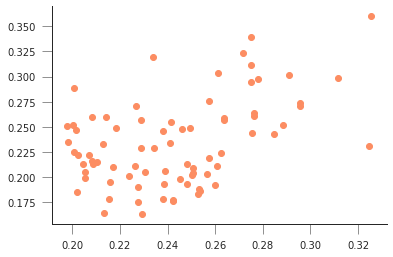

In [695]:
plt.plot(df[f"SM_{field:s}"][passer], [s[1] for s in sols], 'o')

In [341]:
def rmse_prediction(predictions, targets):
    """ calculation of RMSE """
    return np.sqrt(np.nanmean((predictions - targets) ** 2))
def linregress(predictions, targets):
    """ Calculate a linear least-squares regression for two sets of measurements """
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(predictions, targets)
    return slope, intercept, r_value, p_value, std_err

In [345]:
df[f"SM_{field:s}"][passer].values
np.array([s[1] for s in sols])
rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,np.array([s[1] for s in sols]))
slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,np.array([s[1] for s in sols])[:len(df[f"SM_{field:s}"][passer].dropna().values)])
print(rmse*100)
print(r_value)

4.2186683541400845
0.7199780060505114


Initial cost 11074.2
Final cost 207.794
(21.64576703184718-9.12646973510763j)
(-0.22842652974633607-0.14079884366239634j)
16.315745805326685
-0.21576969256335832
Initial cost 12830.3
Final cost 256.77
(29.291164083349802-22.602770248128635j)
(-0.1853480091832193-0.12157006788242394j)
20.29063382739023
-0.21667333432206975
Initial cost 12343.3
Final cost 235.723
(24.496489496332106-25.716065829407686j)
(-0.06276605907485476-0.02118243775375117j)
22.126905012223375
-0.07679943694531259
Initial cost 11349.2
Final cost 207.026
(20.654402876627458-11.649054127211228j)
(0.17263122015757032+0.02795432375663481j)
17.50558987075598
0.17075406961864195


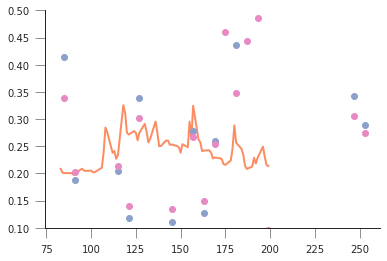

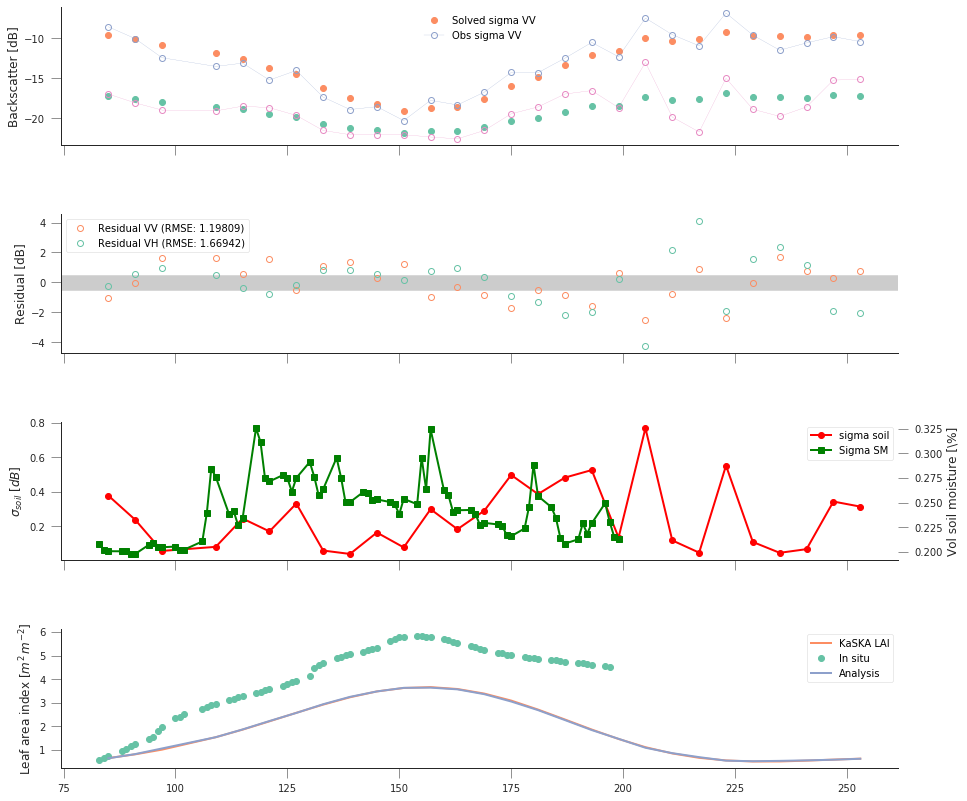

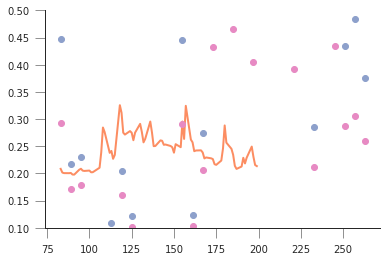

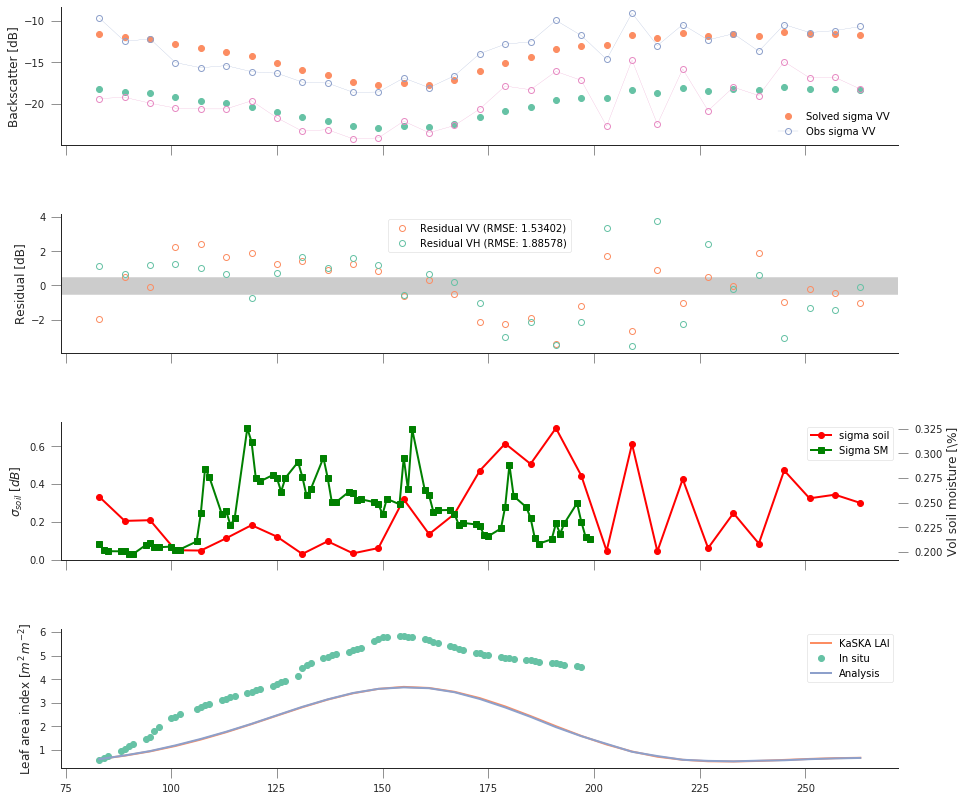

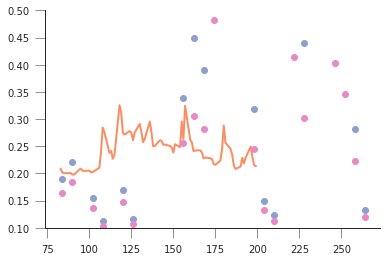

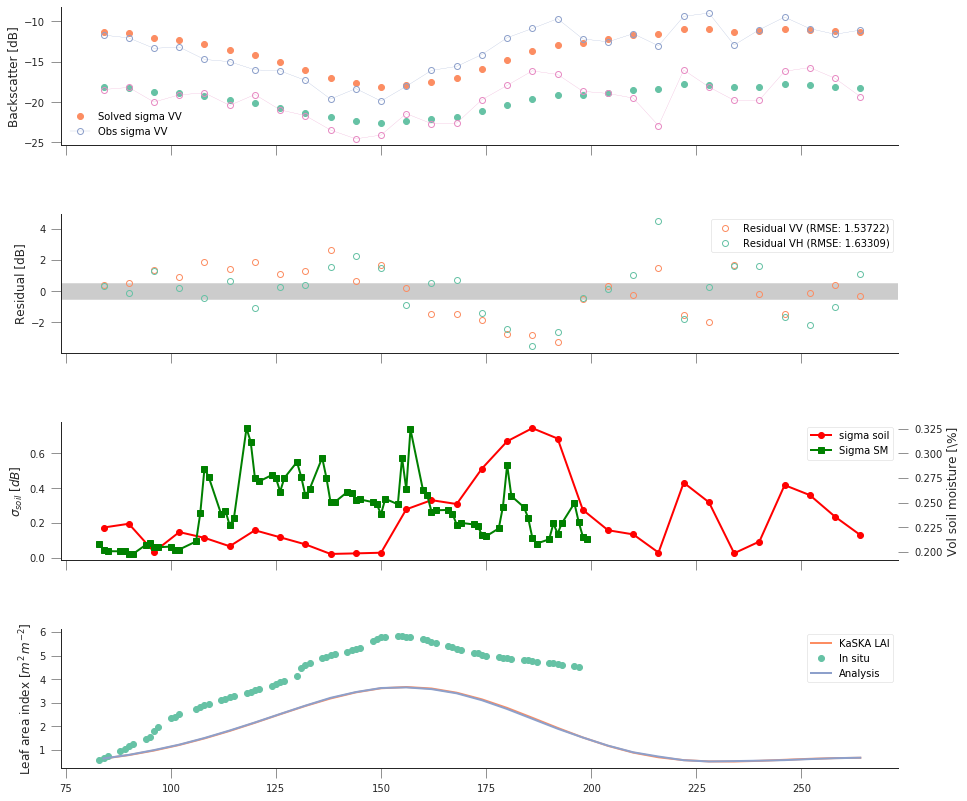

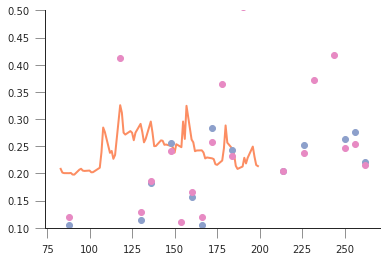

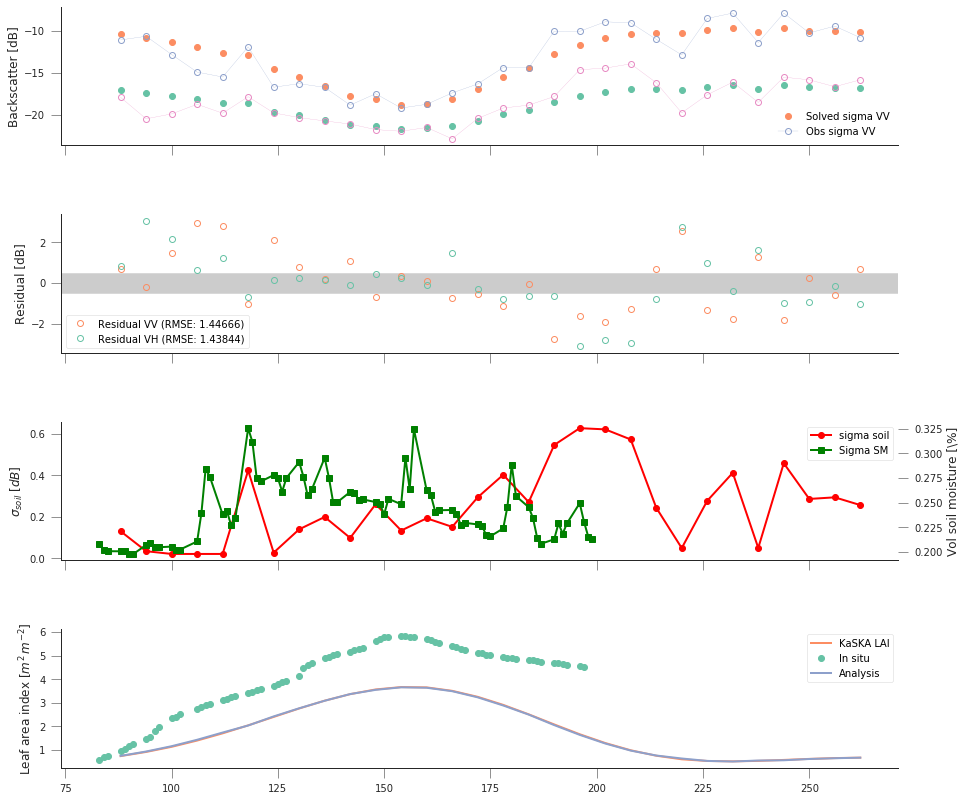

In [700]:
from SAR_retrieval_machinery import *
import random

field = "508"


for orbit_no, orbit_data in prepare_field_data(
                            field, df, df_s2, ignore_orbits=False).items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown, lai = orbit_data
    lai[18:]=0
    lai = lai

    ##rr = np.ones_like(passer, dtype=np.float32)*np.nan

    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_mean = gaussian_filter1d(sm_mean, 3)
    alpha_mean = fresnel(mv2eps(1.99, 38.9, 11.5, sm_mean), theta.mean())
    alpha_mean = np.array([sm+random.uniform(0,0.05) for sm in sm_mean])
    alpha_mean = sm_mean
    #sm_std = 5.*np.nanstd([df[f"SM_{field:s}"][passer]
    #                        for field in fields], axis=0)
    #sm_std[sm_std == 0] = 0.2
    #print(sm_std)
    alpha_std = np.ones_like(alpha_mean)*0.2
#     alpha_mean = np.ones_like(alpha_mean)*0.2




    prior_mean = np.concatenate([[0,]*6, alpha_mean, np.zeros_like(sm_mean), s2_lai])
#     prior_mean = np.concatenate([[0,]*6, alpha_mean, np.zeros_like(sm_mean), s2_lai*s2_cab/100])
    prior_sd = np.concatenate([[10., ]*6, alpha_std, [0.1,]*n_obs, [0.05, ]*n_obs])
    gamma = (5000, 50)
    retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)
#     retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai*s2_cab/100)
    plt.figure()

    #plt.plot(doy, retval.x[6:(6+len(svv))], 'o')
    alpha = retval.x[6:(6+len(svv))]
    ruff = retval.x[6+n_obs:(6+n_obs*2)]
    #print(alpha)
    #print('alpha')
    sols = quad_approx_solver(1.99, 38.9, 11.5,theta, alpha)

    plt.plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"])
    plt.plot(doy, [s[0] for s in sols], 'o')
    plt.plot(doy, [s[1] for s in sols], 'o')
    plt.plot(doy, alpha, 'o')
    #plt.plot(doy, alpha+ruff, 'o')
    plt.ylim(0.1,0.5)

    rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,np.array([s[1] for s in sols]))
    slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,np.array([s[1] for s in sols])[:len(df[f"SM_{field:s}"][passer].dropna().values)])
    print(rmse*100)
    print(r_value)
    rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,alpha)
    slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,alpha[:len(df[f"SM_{field:s}"][passer].dropna().values)])
    print(rmse*100)
    print(r_value)
    #rmse = rmse_prediction(df[f"SM_{field:s}"][passer].values,alpha+ruff)
    #slope, intercept, r_value, p_value, std_err = linregress(df[f"SM_{field:s}"][passer].dropna().values,alpha[:len(df[f"SM_{field:s}"][passer].dropna().values)]+ruff[:len(df[f"SM_{field:s}"][passer].dropna().values)])
    #print(rmse*100)
    #print(r_value)
    #print(retval.x)
    do_plots_(field, retval, svv, svh, theta, doy, df, s2_lai)


In [344]:
df[f"SM_{field:s}"][passer].dropna().values

array([0.205 , 0.1914, 0.1628, 0.1518, 0.2049, 0.2756, 0.2396, 0.253 ,
       0.2365, 0.1745, 0.1522, 0.1545, 0.1946, 0.1388, 0.1543, 0.1271,
       0.1497, 0.1274, 0.2151])

Initial cost 7045.11
Final cost 514.157
[0.17128713 0.19058479 0.19345157 0.18682851 0.23879865 0.20779166
 0.20649998 0.15098176 0.1448741  0.15347517 0.19746944 0.22105337
 0.21575451 0.23078318 0.29022731 0.25031809 0.21421087 0.19825073
 0.13857323 0.21976731 0.18109842 0.17977856 0.2083546  0.18200084
 0.17690101 0.21822325 0.21216755 0.20399764 0.2237016 ]
{}
Initial cost 8095.74
Final cost 544.471
[0.19211939 0.19276253 0.20676454 0.19808255 0.19983346 0.1988893
 0.2024456  0.20091819 0.19904525 0.1837293  0.1678446  0.19183235
 0.20726106 0.20270614 0.2109639  0.23115283 0.23054944 0.21170191
 0.22914059 0.17998796 0.19047426 0.20463448 0.18573577 0.20841437
 0.17642261 0.18905753 0.19530621 0.21401786 0.17951384 0.19117066
 0.1881064 ]
{}
Initial cost 7742.98
Final cost 541.036
[0.19431428 0.21546305 0.20179342 0.20547121 0.20646711 0.20792177
 0.1981883  0.18407335 0.16597169 0.15732282 0.16357004 0.19771973
 0.21881302 0.20070563 0.24330211 0.26672663 0.25057826 0.21525036
 

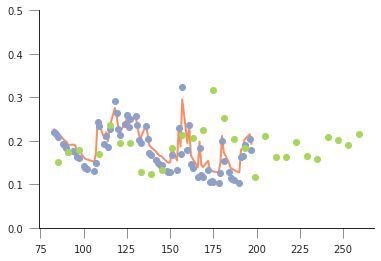

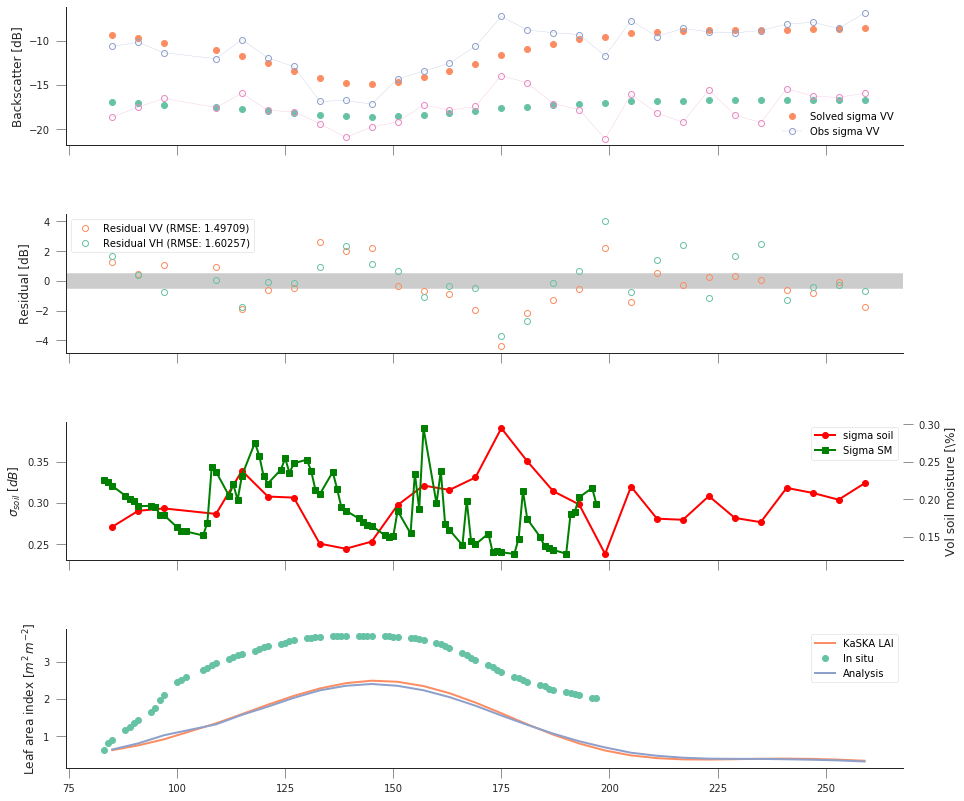

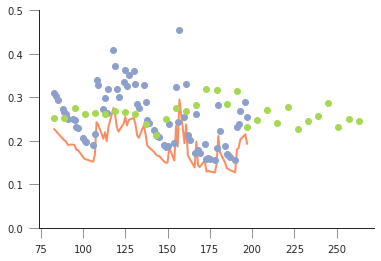

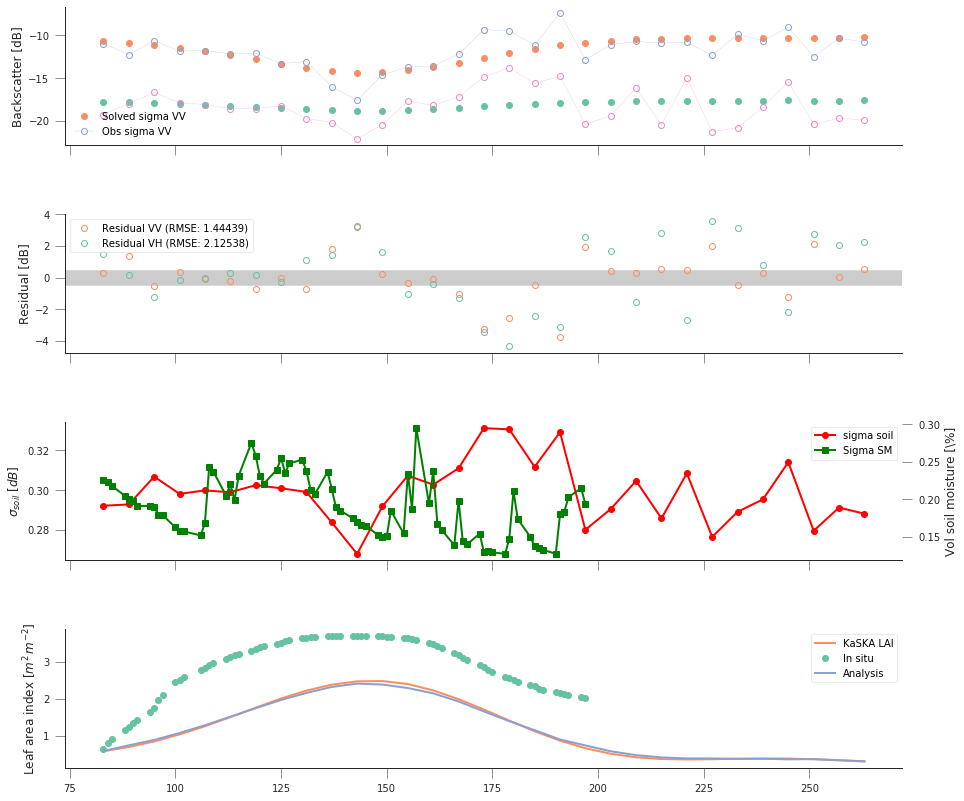

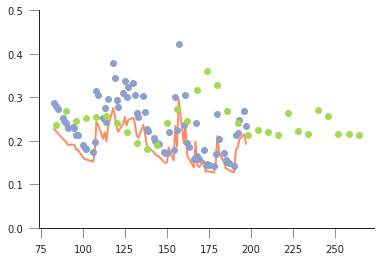

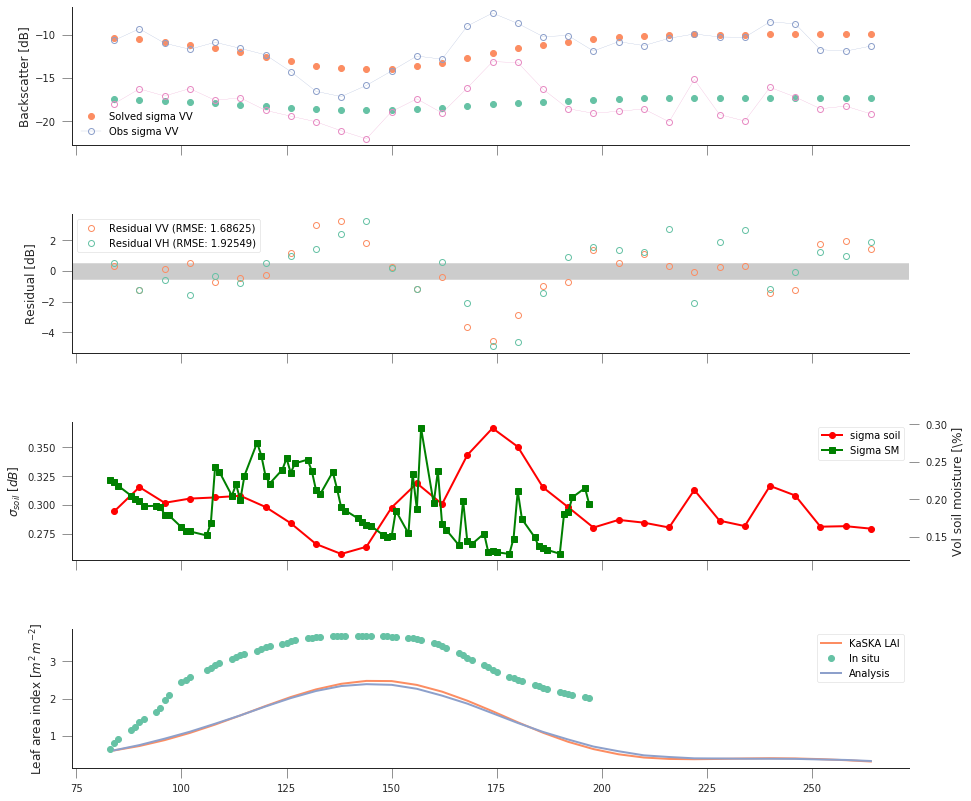

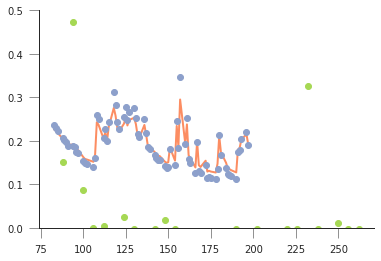

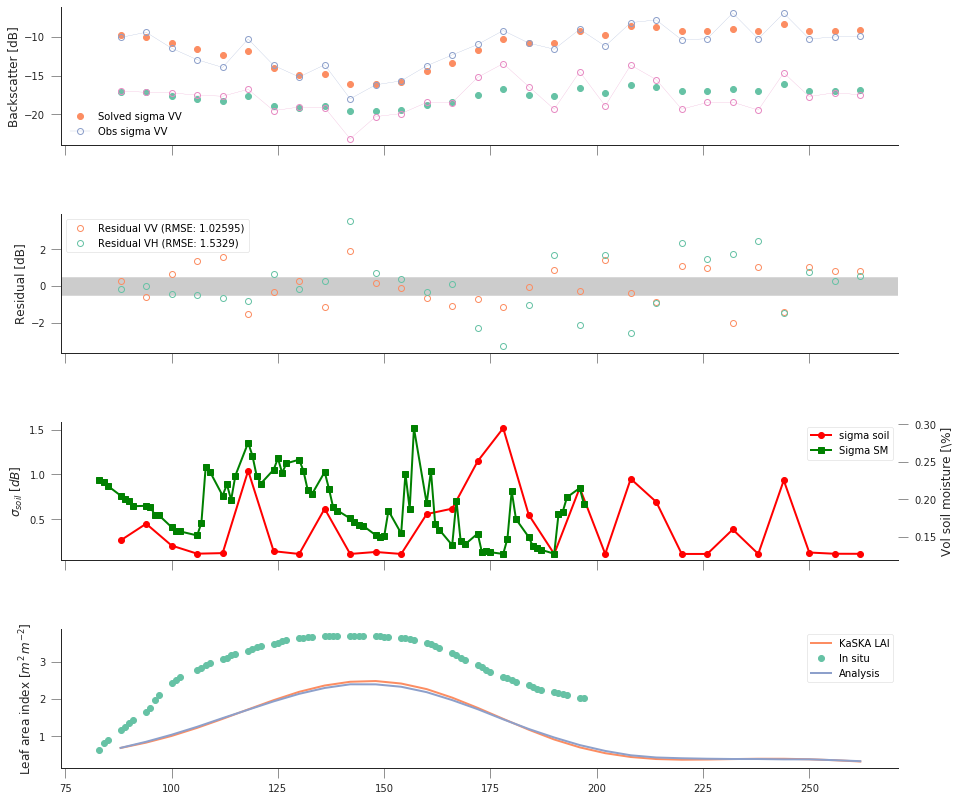

In [669]:
from SAR_retrieval_machinery import *

field = "301"
for orbit_no, orbit_data in prepare_field_data(
                            field, df, df_s2, ignore_orbits=False).items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown, lai = orbit_data
    lai[18:]=0
    ##rr = np.ones_like(passer, dtype=np.float32)*np.nan
    #print(orbit_no) 
    #print(theta)
    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_mean = gaussian_filter1d(sm_mean, 3)
    alpha_mean = fresnel(mv2eps(1.99, 38.9, 11.5, sm_mean), theta.mean())
    #sm_std = 5.*np.nanstd([df[f"SM_{field:s}"][passer]
    #                        for field in fields], axis=0)
    #sm_std[sm_std == 0] = 0.2
    #print(sm_std)
    alpha_mean = np.ones_like(alpha_mean)*0.2
    alpha_std = np.ones_like(alpha_mean)*0.4
    
    
    xxx = np.zeros_like(sm_mean) +0.01

    prior_mean = np.concatenate([[0,]*6, alpha_mean, xxx, s2_lai])
    prior_sd = np.concatenate([[10., ]*6, alpha_std, [0.1,]*n_obs, [0.05, ]*n_obs])
    #prior_mean = np.concatenate([[0,]*6, alpha_mean, lai])
    #prior_sd = np.concatenate([[10., ]*6, alpha_std,  [0.1, ]*n_obs])
    gamma = (10000, 500)

    retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)
    plt.figure()
    
    #plt.plot(doy, retval.x[6:(6+len(svv))], 'o')
    alpha = retval.x[6:(6+len(svv))]
    print(alpha)
    sols = quad_approx_solver(1.99, 38.9, 11.5,theta, alpha)
    sols2 = quad_approx_solver(1.99, 38.9, 11.5,theta, df[f"SM_{field:s}"].dropna())
    
    plt.plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"])
    plt.plot(df[f"doy_{field:s}"][:len(sols2)], sols2, 'o')
    plt.plot(doy, [s[0] for s in sols], 'o')
    plt.plot(doy, [s[1] for s in sols], 'o')
    plt.ylim(0,0.5)
    do_plots_(field, retval, svv, svh, theta, doy, df, s2_lai)
    print(retval.__dict__)


In [71]:
retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, lai)

In [273]:
retval.x

array([  1.09107226,  -0.06807644,  -9.41673088,   1.        ,
         0.5       , -17.2624103 ,   0.20386833,   0.21001891,
         0.19902471,   0.19166739,   0.18773249,   0.2189138 ,
         0.19781893,   0.19029554,   0.20706192,   0.172399  ,
         0.18816887,   0.19088828,   0.203493  ,   0.20964041,
         0.21435191,   0.2217798 ,   0.20568585,   0.19709814,
         0.21083794,   0.19576465,   0.21241425,   0.21358598,
         0.19863529,   0.19943763,   0.21850632,   0.19947011,
         0.2185587 ,   0.19932112,   0.20050829,   0.2004858 ,
         0.03      ,   0.02884269,   0.02860601,   0.02527935,
         0.02416397,   0.02446954,   0.02373717,   0.0240998 ,
         0.0249012 ,   0.02464514,   0.02458231,   0.02695676,
         0.02622018,   0.02729966,   0.02679331,   0.0286121 ,
         0.02840709,   0.02998015,   0.03      ,   0.02994499,
         0.03      ,   0.03      ,   0.02996295,   0.0299775 ,
         0.03      ,   0.03      ,   0.03      ,   0.02

In [252]:
svv

array([-11.06793247, -10.63486258, -12.80668713, -14.8945499 ,
       -15.48213564, -11.89095719, -16.69586227, -16.27087997,
       -16.71620397, -18.82728704, -17.47146969, -19.1721463 ,
       -18.72895202, -17.3754891 , -16.30784143, -14.35333936,
       -14.38898616, -10.03050752, -10.04364805,  -8.91434976,
        -9.02395671, -10.99632871, -12.84832642,  -8.51705903,
        -7.87013815, -11.37868621,  -7.87279846, -10.23650021,
        -9.42333896, -10.79876674])

/home/tweiss/anaconda3_new/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


Initial cost 2591.42
Final cost 376.295
Initial cost 3034.47
Final cost 345.375
Initial cost 2842.61
Final cost 385.012
Initial cost 2797.26
Final cost 354.328


/home/tweiss/anaconda3_new/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


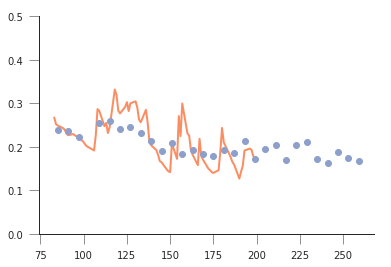

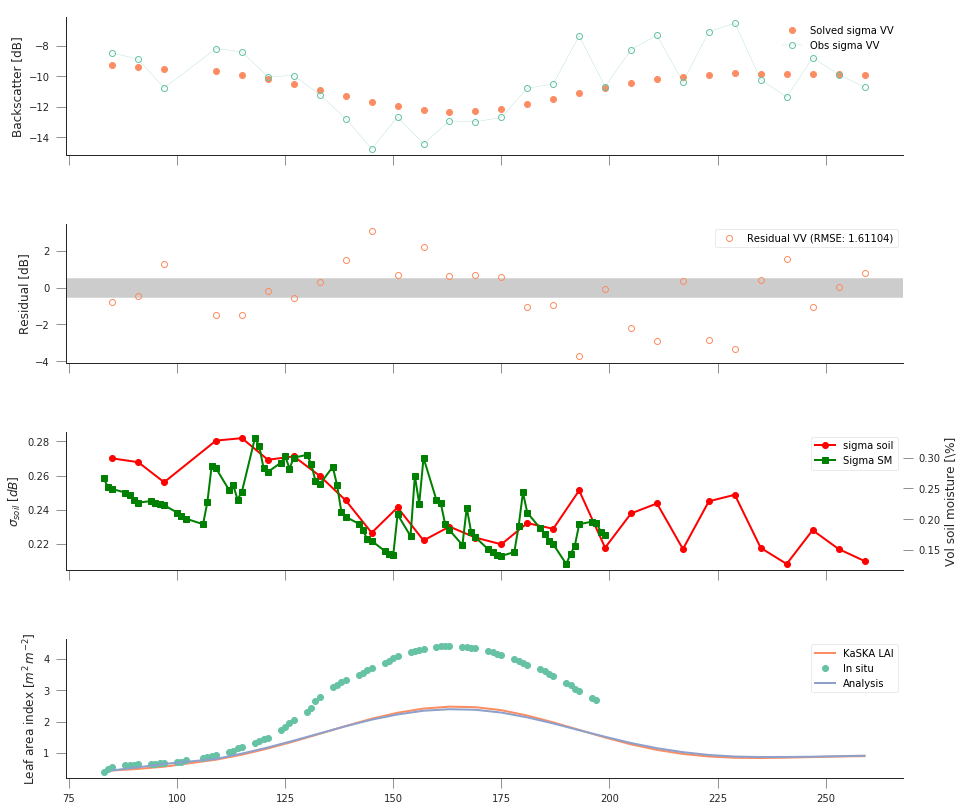

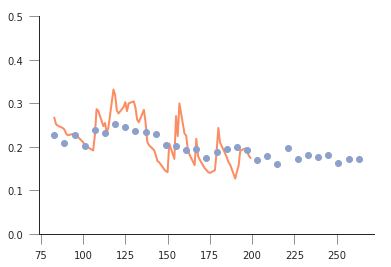

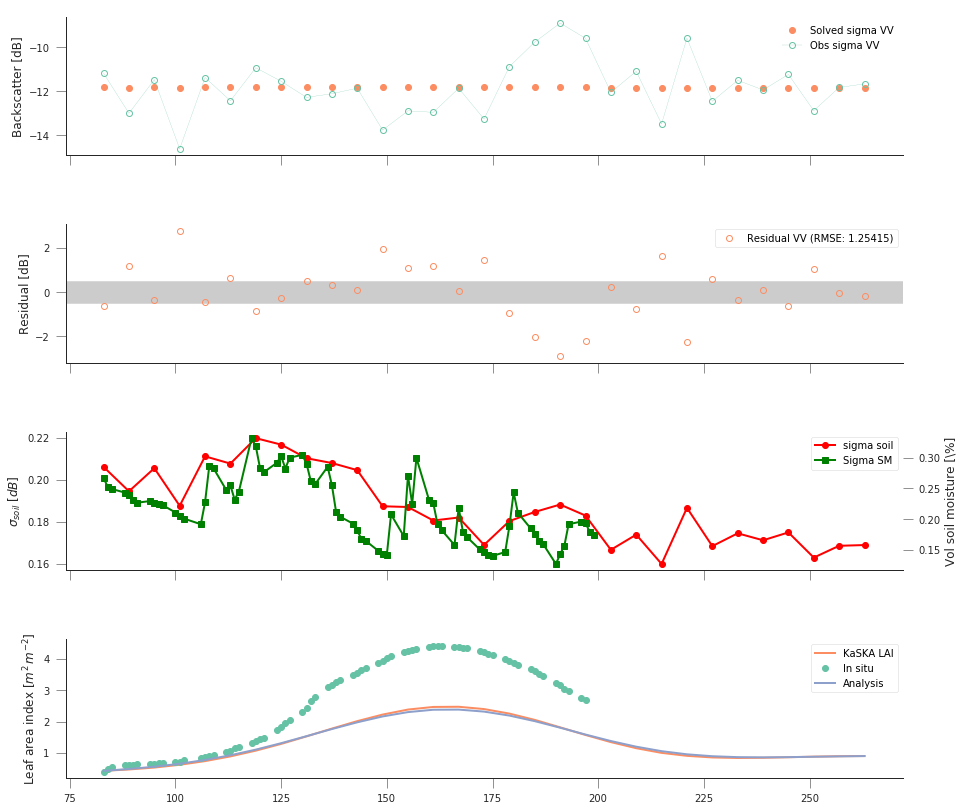

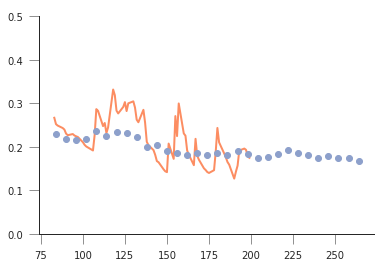

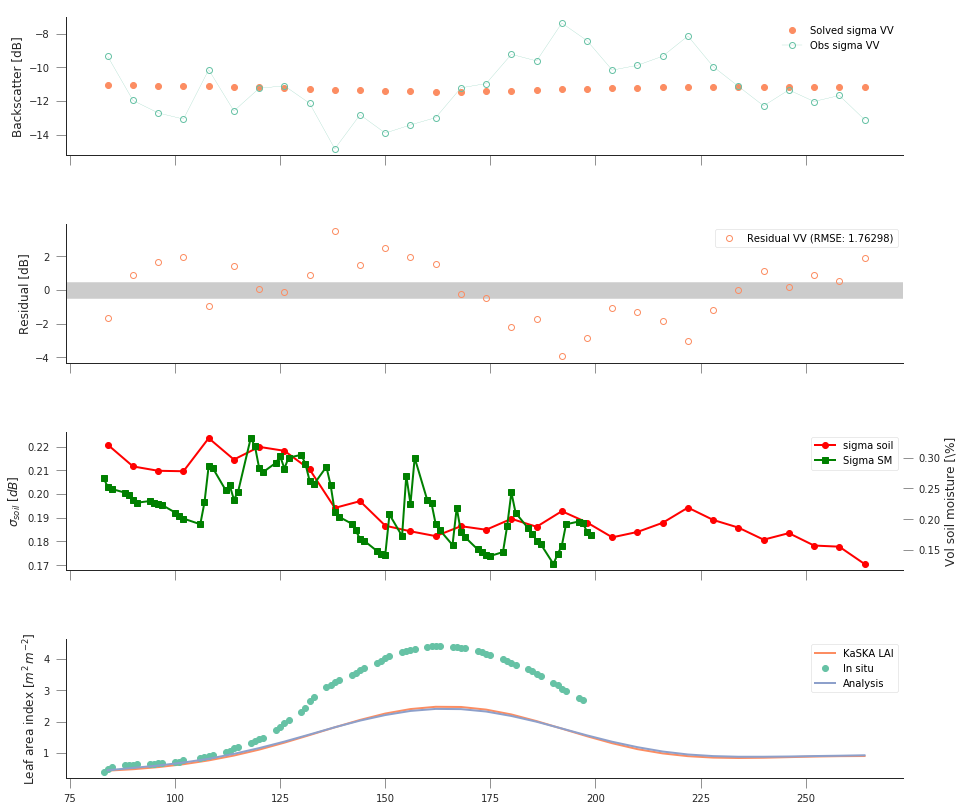

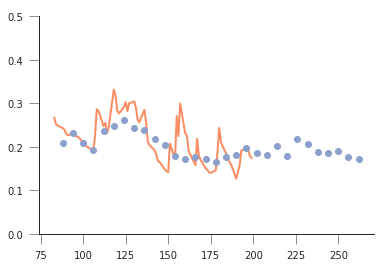

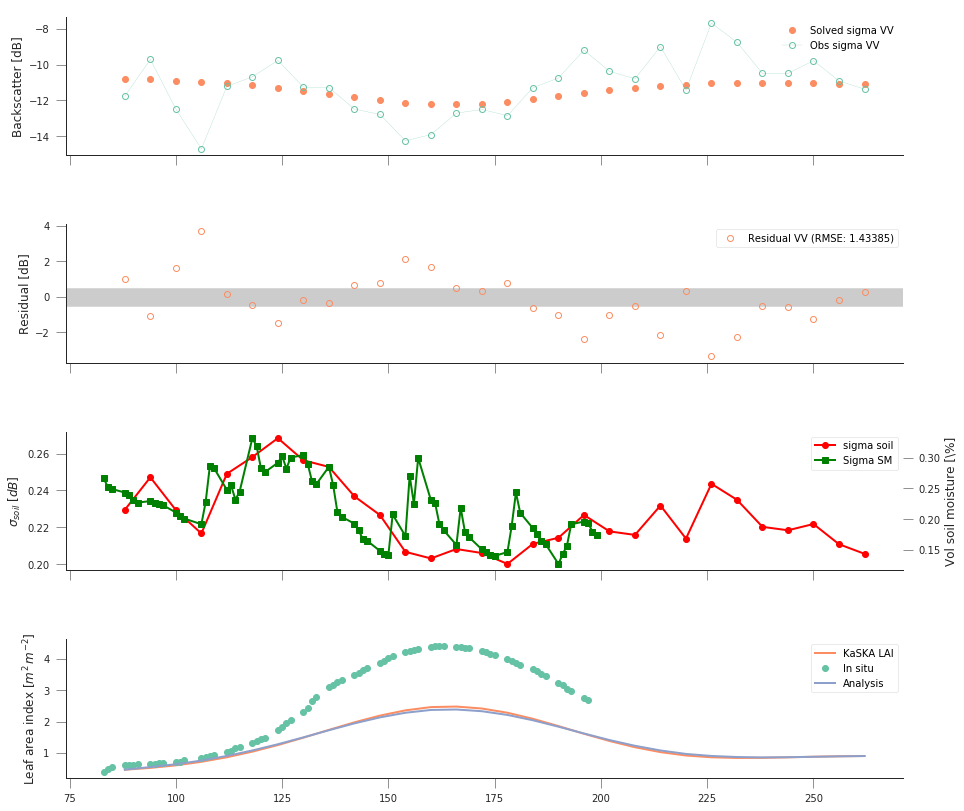

In [43]:
from SAR_retrieval_machinery import *

field = "542"
for orbit_no, orbit_data in prepare_field_data(
                            field, df, df_s2, ignore_orbits=False).items():
    doy, passer, n_obs, svv, svh, theta, s2_lai, s2_cab, s2_cbrown = orbit_data
    ##rr = np.ones_like(passer, dtype=np.float32)*np.nan
    
    sm_mean = np.nanmean([df[f"SM_{field:s}"][passer] for field in fields], axis=0)
    sm_mean = gaussian_filter1d(sm_mean, 3)
    alpha_mean = fresnel(mv2eps(1.99, 38.9, 11.5, sm_mean), theta.mean())
    #sm_std = 5.*np.nanstd([df[f"SM_{field:s}"][passer]
    #                        for field in fields], axis=0)
    #sm_std[sm_std == 0] = 0.2
    #print(sm_std)
    alpha_std = np.ones_like(alpha_mean)*0.2
    
    


    prior_mean = np.concatenate([[0,]*6, alpha_mean, np.zeros_like(sm_mean), s2_lai])
    prior_sd = np.concatenate([[10., ]*6, alpha_std, [0.1,]*n_obs, [0.05, ]*n_obs])
    gamma = (10000, 500)
    retval, residuals = invert_field_(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai)
    plt.figure()
    
    #plt.plot(doy, retval.x[6:(6+len(svv))], 'o')
    alpha = retval.x[6:(6+len(svv))]
    sols = quad_approx_solver(1.99, 38.9, 11.5,theta, alpha)
    
    plt.plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"])
    plt.plot(doy, [s[0] for s in sols], 'o')
    plt.plot(doy, [s[1] for s in sols], 'o')
    plt.ylim(0,0.5)
    do_plots_(field, retval, svv, svh, theta, doy, df, s2_lai)



So it would appear that the retrievals from these experiments suggest a few things:

1. Working on individual orbits is a sensible thing to do
2. Fitting the data is somewhat complicated: as we expand the complexity of the model and increase the parameter space, we increase the solver requirements
3. We haven't passed information from parameters in one orbit to parameters in another orbit (e.g. as a prior), which would be the obvious way to combine things
4. The solution is heavily reliant on the starting point (this is related to point 2), as well as regularisation strength (in effect, a way of "shriking" parameter space).
5. We do not have sensible priors for a lot of the parameters, and we do not enforce it. Maybe there's some way of providing a sensible prior for e.g. roughness or WCM parameters, but not sure how generic this could be
6. The retrieval of soil moisture is heavily dependent on soil texture. We have used Hallikainen's formula ("because it's easy"), but this needs to be parameterised, and possibly fed in as a form of prior.
